### Enhancing Hotel Recommendations Using LLMs

In [3]:
# Installing the latest versions of the Hugging Face Transformers library and Accelerate library
# Transformers: a library for natural language processing tasks like text classification, translation, etc.
# Accelerate: used to easily scale models across different hardware setups (CPU, GPU, multi-GPU, etc.)
# Install the bitsandbytes library
# bitsandbytes: a lightweight library that allows running large language models with fewer bits, enabling memory-efficient model training and inference.

# Installing packages
!pip install watermark
!pip install bitsandbytes
!pip install torch
!pip install spacy
!pip install langdetect
!pip install -U transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 19.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.4 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=960b2c5fe14744703a0241c55c8a9802c53bb6b736ade08b7b9f5b904dc78372
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 71.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 63.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation

In [4]:
# Import of libraries

# System libraries
import re
import os
import unicodedata
import itertools
import string
from collections import Counter

# Library for file manipulation
import pandas as pd
import numpy as np
import pandas

# Data visualization
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib as m
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import spacy
from spacy.lang.en.stop_words import STOP_WORDS as STOP_WORDS_EN  # English stopwords

# Load the English language model from spaCy
nlp_en = spacy.load('en_core_web_sm')

# Configuration for graph width and layout
sns.set_theme(style='whitegrid')
palette='viridis'

# AutoTokenizer: Automatically loads a pre-trained tokenizer for encoding text
# AutoModelForCausalLM: Loads a pre-trained model for causal language modeling (e.g., for text generation)
# pipeline: Provides an easy-to-use interface to perform tasks like text generation, sentiment analysis, etc.
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# CUDA debug
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Warnings remove alerts
import warnings
warnings.filterwarnings("ignore")

# Python version
from platform import python_version
print('Python version in this Jupyter Notebook:', python_version())

# Load library versions
import watermark

# Library versions
%reload_ext watermark
%watermark -a "Library versions" --iversions

# Download necessary resources from NLTK
import nltk
import spacy
nltk.download('punkt')  # Tokenizer models
nltk.download('stopwords')  # Stopwords data
nltk.download('wordnet')  # WordNet lemmatizer data

# Download Spacy language models for English
# English model
!python -m spacy download en_core_web_sm  

Python version in this Jupyter Notebook: 3.10.12
Author: Library versions

transformers: 4.49.0
torch       : 2.4.1+cu121
pandas      : 2.1.4
seaborn     : 0.12.2
platform    : 1.0.8
re          : 2.2.1
spacy       : 3.7.6
matplotlib  : 3.7.1
wordcloud   : 1.9.3
plotly      : 5.24.1
numpy       : 1.26.4
watermark   : 2.5.0
nltk        : 3.2.4

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.1 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in

In [5]:
# Load the dataset
data = pd.read_csv("/kaggle/input/seattle/listings.csv")

# Select relevant columns
columns = ["name", "description", "neighborhood_overview", "price", 
           "review_scores_rating", "amenities", "room_type", "state"]

# Filter the dataset with the selected columns
filtered_data = data[columns]

# Display the filtered dataset
filtered_data

,name,description,neighborhood_overview,price,review_scores_rating,amenities,room_type,state
0,Stylish Queen Anne Apartment,Make your self at home in this charming one-be...,NaN,$85.00,95.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",Entire home/apt,WA
1,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",$150.00,96.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",Entire home/apt,WA
2,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,$975.00,97.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",Entire home/apt,WA
3,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,$100.00,NaN,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",Entire home/apt,WA
4,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,$450.00,92.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",Entire home/apt,WA
...,...,...,...,...,...,...,...,...
3813,3BR Mountain View House in Seattle,Our 3BR/2BA house boasts incredible views of t...,We're located near lots of family fun. Woodlan...,$359.00,80.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",Entire home/apt,WA
3814,Portage Bay View!-One Bedroom Apt,800 square foot 1 bedroom basement apartment w...,The neighborhood is a quiet oasis that is clos...,$79.00,100.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",Entire home/apt,WA
3815,Private apartment view of Lake WA,"Very comfortable lower unit. Quiet, charming m...",NaN,$93.00,NaN,"{""Cable TV"",""Wireless Internet"",Kitchen,""Free ...",Entire home/apt,WA
3816,Amazing View with Modern Comfort!,Cozy studio condo in the heart on Madison Park...,Madison Park offers a peaceful slow pace upsca...,$99.00,NaN,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",Entire home/apt,WA


In [6]:
# Handle missing values
filtered_data.dropna(subset=["name", "description", "price", "review_scores_rating"], inplace=True)

# Normalize text columns
filtered_data["description"] = filtered_data["description"].str.lower()
filtered_data["amenities"] = filtered_data["amenities"].str.lower()

# Display the filtered dataset
filtered_data

,name,description,neighborhood_overview,price,review_scores_rating,amenities,room_type,state
0,Stylish Queen Anne Apartment,make your self at home in this charming one-be...,NaN,$85.00,95.0,"{tv,""cable tv"",internet,""wireless internet"",""a...",Entire home/apt,WA
1,Bright & Airy Queen Anne Apartment,chemically sensitive? we've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",$150.00,96.0,"{tv,internet,""wireless internet"",kitchen,""free...",Entire home/apt,WA
2,New Modern House-Amazing water view,new modern house built in 2013. spectacular s...,Upper Queen Anne is a charming neighborhood fu...,$975.00,97.0,"{tv,""cable tv"",internet,""wireless internet"",""a...",Entire home/apt,WA
4,Charming craftsman 3 bdm house,cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,$450.00,92.0,"{tv,""cable tv"",internet,""wireless internet"",ki...",Entire home/apt,WA
5,Private unit in a 1920s mansion,we're renting out a small private unit of one ...,This part of Queen Anne has wonderful views an...,$120.00,95.0,"{""wireless internet"",""free parking on premises...",Private room,WA
...,...,...,...,...,...,...,...,...
3810,Fremont Farmhouse,our 2br/1 bath home in fremont's most fun neig...,We love that Fremont is so centrally located t...,$154.00,92.0,"{tv,""cable tv"",internet,""wireless internet"",ki...",Entire home/apt,WA
3811,Super Convenient Top Floor Apt,in the true spirit of airbnb this unit is avai...,I am equidistant to Fremont and Wallingford an...,$65.00,100.0,"{tv,""cable tv"",internet,""wireless internet"",""a...",Entire home/apt,WA
3812,OF THE TREE & CLOUDS. KID FRIENDLY!,"of the tree & clouds' ""roots"" apartment is 8 b...",It's taken me a while to figure out why Fremon...,$95.00,96.0,"{internet,""wireless internet"",kitchen,""free pa...",Entire home/apt,WA
3813,3BR Mountain View House in Seattle,our 3br/2ba house boasts incredible views of t...,We're located near lots of family fun. Woodlan...,$359.00,80.0,"{tv,""cable tv"",internet,""wireless internet"",""a...",Entire home/apt,WA


# Section A) Prompt engineering

In [7]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
# Determine the device to use: "cuda" if a GPU is available, otherwise "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display the selected device
device

'cpu'

In [9]:
# Path to the base GPT-2 model
base_model = "gpt2"

In [10]:
# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)

# Load the pre-trained model and move it to the selected device
model = AutoModelForCausalLM.from_pretrained(base_model).to(device)

# Set the padding token
tokenizer.pad_token = tokenizer.eos_token

# Configure the model's padding token ID
model.config.pad_token_id = tokenizer.eos_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [11]:
# Function to format hotel data
def format_hotel_data(hotel):
    """
    Format hotel data for the prompt.
    :param hotel: Dictionary with hotel information.
    :return: Formatted string.
    """
    return (
        f"Name: {hotel['name']}\n"
        f"Description: {hotel['description']}\n"
        f"Location: {hotel['neighborhood_overview']}\n"
        f"Price: {hotel['price']}\n"
        f"Rating: {hotel['review_scores_rating']}\n"
        f"Amenities: {hotel['amenities']}\n"
        f"Room Type: {hotel['room_type']}\n"
        f"State: {hotel['state']}\n"
    )

# Function to recommend hotels
def recommend_hotels(user_input, filtered_data, tokenizer, model, top_n=5):
    """
    Generate hotel recommendations based on user preferences.
    :param user_input: User preferences.
    :param filtered_data: DataFrame with hotel information.
    :param tokenizer: Model tokenizer.
    :param model: GPT-2 model.
    :param top_n: Number of hotels to include in the prompt.
    :return: Generated recommendation string.
    """
    # Create a prompt with user preferences
    prompt = f"Recommend multiple hotels based on the following user preferences:\n{user_input}\n\n"

    # Add the first 'top_n' hotels to the prompt
    for _, hotel in filtered_data.head(top_n).iterrows():
        prompt += format_hotel_data(hotel) + "\n"
    
    prompt += "Please recommend the best options based on the user's preferences and explain why.\n"

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

    # Generate recommendations
    outputs = model.generate(inputs.input_ids,
                             attention_mask=inputs.attention_mask,
                             max_new_tokens=300,  # Allow more tokens in the output
                             temperature=0.7,
                             repetition_penalty=1.2,  # Penalize repetition
                            )

    # Decode the generated text
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

In [12]:
# Recommendation 1
user_input = "I want a hotel with breakfast included, a high rating, and affordable price."

# Generate recommendations based on user input
recommendation = recommend_hotels(user_input, filtered_data, tokenizer, model, top_n=10)

# Display the recommendations
print("Model Recommendations:")
print(recommendation)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model Recommendations:
Recommend multiple hotels based on the following user preferences:
I want a hotel with breakfast included, a high rating, and affordable price.

Name: Stylish Queen Anne Apartment
Description: make your self at home in this charming one-bedroom apartment, centrally-located on the west side of queen anne hill.   this elegantly-decorated, completely private apartment (bottom unit of a duplex) has an open floor plan, bamboo floors, a fully equipped kitchen, a tv,  dvd player, basic cable, and a very cozy bedroom with a queen-size bed. the unit sleeps up to four (two in the bedroom and two on the very comfortable fold out couch, linens included) and includes free wifi and laundry. the apartment opens onto a private deck, complete with it's own bbq, overlooking a garden and a forest of black bamboo.    the apartment is perfectly-located just one block from the bus lines where you can catch a bus and be downtown seattle in fifteen minutes or historic ballard in ten or 

In [13]:
# Recommendation 2
user_input = "I want a hotel with breakfast, good ratings, and affordable prices."

# Generate hotel recommendations based on user preferences
recommendation = recommend_hotels(user_input, filtered_data, tokenizer, model, top_n=10)

# Display the generated recommendations
print("Model Recommendations:")
print(recommendation)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model Recommendations:
Recommend multiple hotels based on the following user preferences:
I want a hotel with breakfast, good ratings, and affordable prices.

Name: Stylish Queen Anne Apartment
Description: make your self at home in this charming one-bedroom apartment, centrally-located on the west side of queen anne hill.   this elegantly-decorated, completely private apartment (bottom unit of a duplex) has an open floor plan, bamboo floors, a fully equipped kitchen, a tv,  dvd player, basic cable, and a very cozy bedroom with a queen-size bed. the unit sleeps up to four (two in the bedroom and two on the very comfortable fold out couch, linens included) and includes free wifi and laundry. the apartment opens onto a private deck, complete with it's own bbq, overlooking a garden and a forest of black bamboo.    the apartment is perfectly-located just one block from the bus lines where you can catch a bus and be downtown seattle in fifteen minutes or historic ballard in ten or a quick f

In [14]:
# Recommendation 3
user_input = "I want an affordable hotel with complimentary breakfast and high ratings."

# Generate hotel recommendations based on user input
recommendation = recommend_hotels(user_input, filtered_data, tokenizer, model, top_n=10)

# Display the generated recommendations
print("Model Recommendations:")
print(recommendation)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model Recommendations:
Recommend multiple hotels based on the following user preferences:
I want an affordable hotel with complimentary breakfast and high ratings.

Name: Stylish Queen Anne Apartment
Description: make your self at home in this charming one-bedroom apartment, centrally-located on the west side of queen anne hill.   this elegantly-decorated, completely private apartment (bottom unit of a duplex) has an open floor plan, bamboo floors, a fully equipped kitchen, a tv,  dvd player, basic cable, and a very cozy bedroom with a queen-size bed. the unit sleeps up to four (two in the bedroom and two on the very comfortable fold out couch, linens included) and includes free wifi and laundry. the apartment opens onto a private deck, complete with it's own bbq, overlooking a garden and a forest of black bamboo.    the apartment is perfectly-located just one block from the bus lines where you can catch a bus and be downtown seattle in fifteen minutes or historic ballard in ten or a q

In [15]:
# Recommendation 4
user_input = f"""
You are a travel recommendation assistant. Your task is to recommend the top {30} hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.
"""

# Generate recommendations
recommendation = recommend_hotels(user_input, filtered_data, tokenizer, model, top_n=10)

# Display recommendations
print("Model Recommendations:")
print(recommendation)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model Recommendations:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Stylish Queen Anne Apartment
Description: make your self at home in this charming one-bedroom apartment, centrally-located on the west side of queen anne hill.   this elegantly-decorated, completely private apartment (bottom unit of a duplex) has an open floor plan, bamboo floors, a fully equipped kitchen, a tv,  dvd player, basic cable, and a very cozy bedroom with a queen-size bed. the unit sleeps up to four (two in the bedroom and two on the very comfortable fold out couch, linens included) and includes free wifi and laundry. the apartment opens onto 

In [16]:
%%time

# Define the batch size for processing
batch_size = 10

# Process the data in batches
for i in range(0, len(filtered_data), batch_size):
    # Select a batch of data
    batch = filtered_data.iloc[i:i + batch_size]
    
    # Generate recommendations for the current batch
    recommendation = recommend_hotels(user_input, batch, tokenizer, model, top_n=len(batch))
    
    # Display the recommendations for the current batch
    print(f"Recommendations for batch {i // batch_size + 1}:")
    print(recommendation)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 1:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Stylish Queen Anne Apartment
Description: make your self at home in this charming one-bedroom apartment, centrally-located on the west side of queen anne hill.   this elegantly-decorated, completely private apartment (bottom unit of a duplex) has an open floor plan, bamboo floors, a fully equipped kitchen, a tv,  dvd player, basic cable, and a very cozy bedroom with a queen-size bed. the unit sleeps up to four (two in the bedroom and two on the very comfortable fold out couch, linens included) and includes free wifi and laundry. the apartment opens

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 2:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Upper Queen Anne Craftsman House
Description: beautifully furnished, cozy 1 bedroom mid century modern craftsman house in upper queen anne. 850 sqft - queen sz bed, large closet, huge dining table, comfy living room, bathtub, fully furnished kitchen, outdoor patio. very walkable neighborhood! beautiful home in an extremely walkable neighborhood with restaurants, coffee shops, bars, stores. just blocks away from bus stops. convenient to downtown, seattle center, the space needle, ballard, fremont. i will likely not be present during your stay, but w

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 3:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Lovely Queen Anne home
Description: welcome to seattle! enjoy your stay in a  turn-of-the-century queen anne home. lovely setting in the heart of the city. cosy up with a cup of coffee in the window seat or enjoy all of the fabulous seattle restaurants, cafes and shops 1 block away. centrally located spacious home in the heart of the city- 1 block away from world class restaurants, cafes and shops.  the house is across the street from a soccer field and park making it a perfect location for kids. start your morning with an el diablo cafe and then e

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 4:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: The Hideaway- Queen Anne/downtown
Description: welcome to the queen anne hideaway.  your home away from home is a lower level unit below a vintage queen anne landmark home.  take advantage of an incredible savings over a hotel in a pet and family friendly environment.  pet friendly flooring, dog bed, kennel, and a fenced yard make this the perfect spot to vacation with your pups.   beautifully furnished, luxury beds with feather toppers, patio with fenced yard, and all the details you need to make your stay perfect.  our apartment has two bedroom (

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 5:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: One bedroom with Lounge
Description: this large, remodeled daylight basement space includes a private entrance, private bedroom with queen bed and closet, a full bathroom and laundry room, mini fridge, massive tv and comfy couch. at the top of queen anne, downtown is a 5 min drive away. with a comfortable space for lounging and having guests and a secluded work area complete with a desk, this basement can host those liking to relax with a beer and watch the big game or those looking to do business or explore seattle.  the daylight basements gets lo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 6:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Bright & Airy room w/ $1M views
Description: private bedroom w/ private bath in clean and modern home with stunning views of puget sound. located in charming queen anne neighborhood quiet, quaint, and very walkable -- just minutes walk to numerous restaurants, bars, cafes, shopping. several bus routes with stops just a couple blocks away. your room - private bedroom with in-room bath the home - 2 bedroom penthouse home, open floor plan, floor to ceiling windows with stunning views of puget sound and the olympic peninsula you'll have access to all o

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 7:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: **Be in the MIDDLE OF EVERYTHING!*
Description: our place is in the awesome ballard neighborhood of seattle w/ its own busy downtown! 4 miles from the seattle center easypublic transportation or you can drive :) or bike. belltown approx 10min. you can walk to everything! we are on the main street. hey potential guests! thanks so much for checking out our listing! welcome to our fun, lively, downtown ballard apartment! the listing is for your own private room with twin bunk beds and comfy mattresses on the floor for guests 3&4. large windows in room

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 8:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Beautiful Ballard condo with view!
Description: my beautiful 2-bedroom condo is in the heart of ballard.  southwest facing with mountain views, this light-filled space is a great place to hang out or to explore from, just 5 blocks to downtown ballard or an easy bus ride downtown. check it out! beautiful condo facing south and west with an open living room/kitchen area and 2 spacious bedrooms (ceiling fans included!).  main living space has a view of mt. rainier and the olympics and offers front-row seats to amazing sunsets. comfortable sleeping for

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 9:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Pvt. Entrance Bedroom&Bath-Ballard
Description: a perfect, private guest suite in a brand new home located in heart of ballard. blocks away from ballard downtown with many of seattle's best dining options. room includes a comfy bed, tv with cable & a private bathroom. come stay with us in seattle! looking for that awesome seattle experience, want to be within blocks of everything but still get a great night sleep. while we don't have a full place for rent, you do have your own private suite with a bed and bath within blocks of downtown ballard. ide

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 10:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Apartment in Downtown Ballard
Description: one bedroom apartment in the heart of ballard.  it is a one bedroom with a double bed and a futon bed in the living room.   it is in the heart of ballard in walking distance to the locks, lots of great restaurants, coffee shops, and breweries. it is a modern, clean and fun apartment in the middle of downtown ballard. we are located in the hot spot of seattle.  you are surrounded by coffee shops, restaurants, breweries and more.  a fun atmosphere to be in!  you can walk to the chittenden locks, and are a s

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 11:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charming 1919 cottage in Ballard
Description: enjoy your own place in the sweet spot of  ballard.  nearing 100 year old home that is "cuter on the inside"  with the dream location where a car isn't necessary but off street parking in your own driveway is provided. easy walk to every amenity a visitor would want. our 1919 vintage house is comfortable, clean, well furnished in "mid -century scandinavian cottage"-style with colorful art and tasteful decor.  the exterior of the house and landscaping aren't pristine but it is like a good baguette: rust

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 12:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Odd Lodging in the Heart of Ballard
Description: we have a 1 queen bed apartment with a full kitchen and private bath in the back of our building very close to downtown ballard. there is an exterior space outside the apartment shared with our members.   check out our detailed description. the building is owned and managed by the independent order of odd fellows ballard-alki lodge #170. originally built in 1903, it has been a fixture of the ballard community from the time its doors first opened. we have two meeting halls, an active rental calendar,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 13:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: A Friendly Place in Ballard
Description: you'll have the first floor of our ballard townhome all to yourself with living room and kitchen upstairs. it's just a 15 minute walk from downtown ballard with easy bus access to downtown seattle and neighboring fremont and wallingford.       clean bedroom with private .75 bath on the first floor of our townhome.  you'll have access to our little garden directly from your room.  our room is perfect for couples or single travelers. the bed in the room is expandable from twin size to queen. just a few blocks

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 14:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cozy 1BD in Storybook Ballard Home
Description: enjoy the comfort and quirks of ballard in a cozy and clean 1bd garden apartment on a block of storybook brick homes. easy walk to restaurants and activities. quick commute by car, bus or bike to downtown, south lake union, or uw.  this is a modest but clean basement apartment in a family-occupied home. the space includes one bedroom, small and open living room and kitchen with eating space for two, and 3/4 bath. there is off-street parking from the alley and room for bike storage in the garage. gues

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 15:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Vintage Ballard Charm
Description: this 1940s one bedroom duplex is located in east ballard, mere feet from bus lines. sleeps two or four with full size sofa bed. walking distance from ballard market, veraci pizza, slate coffee, a super hip pub and 4 different micro-breweries. this 1940's cottage has all original fixtures and finishes. furnished with mid-century and vintage pieces, including original nelson bubble lights. fully stocked kitchen, including locally roasted coffee and a few beers in the kitchen. queer friendly. bedroom with queen foam

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 16:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Priv.RM Olympic View 4m Sunny Loft
Description: enjoy your stay in an artsy loft. this quirky split level house has a sun room crafting space, lofted kitchen with a view, and private room complete with a costume closet. plus coffeeshop, restaurant, beer garden and bus lines are a block away. the house is split into three units. i live in the back upstairs unit. on the main floor is the sunroom living room and the rest is upstairs. the roof top view, cozy sunroom, and artsy quirks make this place a real treat. not to mention the added bonus of gett

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 17:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Modern Ballard/Fremont Cottage
Description: a bright craftsman cottage with modern charm in the middle of seattle's great neighborhoods, fremont and ballard. easily enjoy the trails and ales of seattle by foot, bike, or bus. room for 2 in the cozy, sunny space.  our backyard cottage is a quiet spot for up to 2 people to call home during your visit to lovely seattle - a bright, cozy, and modern 1b/1b with a private entrance for you to come and go as you please. the cottage is heated to keep you warm. french doors open to the side yard, with built-i

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 18:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Relaxing room available
Description: this quiet, bright room is perfect for you.  you'll enjoy your own bathroom (with a tub if you'd like to soak) and have access to a great kitchen and spacious living room.  make a smoothie and watch the sunrise or explore the city! we have a lanai facing the east that offers beautiful views of the sun rising over the mountains and lake. the open living room and kitchen are perfect for playing and relaxing. the kitchen is stocked with the essentials and the neighborhood is both quiet and close to everything. wal

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 19:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Top of Queen Anne 3 Bed / 2 Bath
Description: our home is on top of queen anne and walking distance to all the stores, coffee shops, restaurants and bars. wood floors, vaulted ceilings, chef's kitchen, open floor plan flooded with natural light. three bedrooms and two full bath. 2 to 6 people. a community within walking distance of downtown, queen anne is situated just north of seattle center and south of fremont across the lake washington ship canal.   as a neighborhood, queen anne can refer either to the entire hill or to the central residential

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 20:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Queen Anne Condo 
Description: this 800 square ft condo in queen anne, less than a mile from the space needle with easy access to downtown and the airport.  located right off hwy 99 and within walking distance to all major bus routes. tons of beautiful nautral lighting (180 degree windows). remodeled kitchen and bathroom. seattle center, major bus lines, space needle, downtown, shopping, restaurants no interaction with the guests. yes, right on all the major bus routes. walking distance to monorail
Location: nan
Price: $195.00
Rating: 82.0
Ameniti

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 21:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Queen Anne Living
Description: tastefully appointed, quiet, 1-bedroom condo, between lower & upper queen anne with a beautiful view of sunrise on lake union and the cascades! walk to qfc, south lake union high-tech area, seattle center, parks, & the top of queen anne. pets? ask! buses to downtown in front of building, walking distance to seattle center, south lake union and upper queen anne
Location: nan
Price: $130.00
Rating: 100.0
Amenities: {tv,"wireless internet",kitchen,"free parking on premises","pets allowed","elevator in building",heating,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 22:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Apt on Lake Union & inHeart of City
Description: cookbook authors rad, little 1 bedroom apt overlooking lake union. amazing east-facing sunrise view of mountains & lake. full herb garden (while it lasts) & well-appointed kitchen for cooking & baking during your stay and a well-stocked urban pantry! rad little one bedroom apt overlooking lake union. amazing east-facing sunrise view of mountains & lake. full herb garden (while it lasts) & well-appointed kitchen for cooking & baking during your stay. well-stocked urban pantry full of handmade preserv

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 23:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Spacious Queen Anne Craftsman
Description: three-bedroom two-bath craftsman just one block from queen anne ave, with great restaurants, coffee, and shopping. our neighborhood is less than a 10 minute drive to downtown, south lake union, fremont, etc. three queen beds sleep 6. guests have full access to the house, including laundry facilities. i am available by text any time should you have any issues - please feel free to contact me! queen anne ave. (just one block from 1st ave n.) features a large variety of restaurants and shops, as well as safe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 24:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: lakeview in QueenAnne near Fremont
Description: amazing lake view from balcony in clean, modern apt building in safe neighbourhood in trendy queen anne neighborhood. bus stop downstairs, zip to downtown - straight shot in 20 min. off street parking (not on premises). wifi available only in lobby. please feel free to contact us with any additional questions. downtown/seahawks stadium: 5 min drive, busline: 2 min walk, fremont/south lake union: walking dist, queen anne: 5 min drive, capitol hill/uw: 10 min drive
Location: nan
Price: $94.00
Rating: 8

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 25:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Modern Green Lake Apartment
Description: completely self-contained modern apartment close to greenlake, tangletown and the downtown bus route.   with a private entrance and kitchen this one bedroom apartment comfortably accommodates 2 people.  this is a basement apartment and the ceilings can be a little low in places, six footers should consider that when booking. guests have access to a full size washer and dryer in the apartment as well as wireless internet access. wallingford is a fantastic neighborhood for kids and adults alike with the proxi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 26:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charming Wallingford Apartment
Description: spacious, well-lit mother-in-law apartment located in the basement of a 1920's “seattle box" style single family house in the center of wallingford. the rental is a spacious, well-lit mother-in-law apartment located in the basement of a 1920's “seattle box" style single family house.  the apartment has a separate entrance along the side of the house, a well equipped kitchen, washer and dryer, wifi and appletv.  the bedroom has a queen sized bed and the living room has a sofa bed.  the property is kid-fri

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 27:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Full Apt w/ Garden- cozy and light
Description: warm 1-bedroom private apartment located in the middle of charming and walkablevery comfortable bed. bus stop to downtown 50ft away.  the apartment sits in 1920's house with a lovely garden: perfect for enjoying breakfast while soaking up some seattle sun. i live about 15 minutes away and happy to act as guide, be a resource during your stay, and still provide you privacy. wallingford is a cozy pocket of seattle located directly north of lake union, with eccentric fremont and ballard to the west and 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 28:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: The Silhouette - Lake Union Seattle
Description: enjoy your stay in seattle by staying on lake union right by gas works park and  just 15 minutes walk from the fremont area. fabulous views of the space needle, 4th july fireworks, lake union & seattle. 3 double staterooms and 3 baths. sleeps 6. the silhouette is a 63ft power yacht. kitchen with dishwasher, microwave and fridge/freezer. large main salon with flat screen digital cable tv, stereo and dining area seating 6. the stairs to upper fly bridge are in the main salon.  master king size statero

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 29:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Wallingford, Private 1Bd Apartment!
Description: your own private 1 bedroom apartment in the heart of wallingford.  walking distance to uw, gasworks park, burke gilman trail, fremont, wallingford shops & restaurants enjoy your own private apartment just steps from gasworks park, university village, and burke gilman trail. the apartment unit is a mother-in-law unit in house in the wallingford neighborhood of seattle. the house was built in 2002. the entrance is from the backyard of the house.  the unit is a mother-in-law suite in the basement of th

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 30:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: South Wallingford Casita
Description: 1 bedroom charming getaway in my peaceful and holistic wallingford craftsman home, 2 blocks from gasworks park and burke-gilman trail.  breathe in nature from the aspiring habitat garden and begin and end your day with the "earth move" on the patio, garden, or decks.  the home and fenced grounds are shared by my 9 year old golden doodle "happy" and me in the upper unit and long-term tenants on the middle floor.  the private entrance into the basement b&w opens directly into the garden and patio, with bbq and t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 31:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Modern and Cozy Bedroom
Description: this comfy cozy bedroom with modern touches is the perfect spot to unwind at the end of a work day or spend time on a weekend trip! it comfortably fits two people. you'll love taking a walk to greenlake or nearby shops and being seconds from i-5! our large home in the wallingford neighborhood is very cozy. filled with sentimental knick-knacks, handcrafted furniture, and some modern touches, you'll feel right at home. with large windows in the front room, there is a ton of light in the common spaces! our weimara

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 32:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Greenlake Classic 2 Bdrm Craftsman 
Description: our pictures will tell the story of a charming holiday villa located in the popular urban neighborhood of greenlake, just north of downtown seattle. once inside you will instantly feel welcomed by the traditional décor and mid-century appeal. with room for 6 guests, this home offers everyone the opportunity to come together or catch a quiet moment on their own. the living room is the perfect setting to enjoy a board game, movie or share tales of recent adventures. leaded glass windows in both the li

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 33:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charming Seattle basement apartment
Description: wallingford is minutes from downtown and even closer to uw, greenlake and lake union. our comfortable one bedroom basement apartment is on a dead end street next to a wonderful park. it features a private entrance, off street parking, and is pet friendly. close to everything seattle has to offer. james has worked in architectural salvage for many years. the first on the job to historic buildings,  homes, and business being torn down.  he has an eye for the diamond in the rough and you will see this 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 34:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Spacious 2Br home sleeps 6, HotTub!
Description: this unique home includes stunning vaulted ceiling living space, all modern appliances, a japanese-style rock garden with koi pond, and hot tub! very accessible location just minutes from downtown and easy walk to stores & the popular greenlake park. this home was recently remodeled and updated, and infused with a variety of novel design elements. 2 full bedrooms with queen beds plus a sleeper sofa will accommodate 6 adult guests! three bathrooms total, including a full, 3/4, and 1/2 bath. i'll like

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 35:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charming stay near Greenlake.
Description: private bedroom with a full bed in the basement suite of our recently renovated craftsman home. the suite has two rooms, both rentals through airbnb. it can comfortably accommodate 4 guests.  private bedroom with a full bed in the basement suite of our recently renovated craftsman home. the suite has two rooms, both rentals through airbnb. each room can comfortably accommodate 2 guests.  the suite includes a shared kitchen, living room, laundry room, and bath room. internet access and parking are included

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 36:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Stylish Wallingford 1-BD Apartment
Description: located in seattle's eclectic wallingford neighborhood. city view streets and just blocks away from lake union, the burke gilman trail,  coffee shops, restaurants, bars, and shopping. easy transit access to downtown and the uw. this is a spacious, well-lit mother-in-law apartment in the basement level of our seattle home. all new furniture and decor. our wallingford neighborhood location provides walking to nearby grocery, renowned restaurants (including westward, the award winning waterfront restaur

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 37:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cozy 1BD in Fremont/Wallingford!
Description: our cozy, day-light basement mother-in-laws apartment has its private entrance in the back with a private garden and deck. it can accommodate two visitors and provides an incredible central location to explore all seattle has to offer. day light basement mother-in-law in a charming 1920s craftsman home, lovely landscaping and gardens. will accommodate two of you, but best for a single person. the step up in the bathroom creates a height restriction and may not work for taller guests. with a walk score 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 38:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Panoramic Water Views - 6bd/3ba
Description: our nw style home is 3200+ sq ft with 3 levels, having 2 living areas, 6 separate bedrooms, 2 kitchens (1 is kitchenette), 3 full baths, 2 outdoor decks, backyard garden, parking & laundry. space has nice furnishings, is simple and very clean. the location and views of our home make it very special. we have sweeping views of lake union, from i-5 bridge to the space needle.   there is no tv, but if you bring a computer with hdmi cable port, you can plug into our  a projector and large movie screen that y

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 39:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: BLUE SUITE - super clean - new bed
Description: renovated craftsman home  |  new bed  |  fits two |  centrally located  |  spacious kitchen  |  lovely courtyard bistro  |  free parking  |  awesome business workspace  |  super-speed wifi 1-gig (phone number hidden) of three rooms offered on airbnnb the blue suite - super comfortable, super clean, super quiet.  five blocks from greenlake & other seattle adventures! this spacious private suite is a fantastic space for your seattle stay. comfortably fits two with a brand-new queen size bed & lots of s

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 40:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cozy 1 Bedroom in Queen Anne
Description: cozy 1 bedroom centrally located near ballard, fremont and queen anne. clean and inviting with tons of natural light, a sun deck in the front and a private patio in the back. you will sleep soundly on the comfortable king sized bed. the apartment is cozy and a little secluded from the rest of the city. with the private patio in the back, sun deck in the front, you'll feel right at home with everything you need to have a great stay. feel free to use the hammock in the back, just be sure to roll it back up o

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 41:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Modern Home, Kid-Friendly with View
Description: our 2 bedroom, 2 bath home has an amazing view, lots of light, and a modern aesthetic. we are located on queen anne hill, just 10 minutes from the city. for those with kids, we have lots of toys, kid-gear, and a fenced, kid-friendly private backyard. we are a family of 5, and we rent our home when we travel. our home is a recently remodeled mid-century modern with a beautiful view of elliot bay, magnolia and the olympic mountains.  the house faces west, gets lots of light, and you can watch the ferr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 42:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Inn of Twin Gables - North Room
Description: an elegant choice, our largest room within this seattle bed & breakfast has a queen bed & private bath with tub & hand-held shower. with asian art and soft, rich, restful colors based on the mellow radiance of wood tones, the north room looks out on a large red cedar tree.  the north room adjoins the east room with the possibility of becoming a suite for four.  the inn of twin gables is a seattle bed and breakfast inn offering three comfortable guest rooms and a fully equipped 2-bedroom apartment with f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 43:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Queen Anne, Seattle
Description: safe central location. high walk-ability score. many good restaurants, shops. enjoy a private room in the north slope of queen anne.  the apartment is in a quiet neighborhood and has convenient access to downtown, fremont, ballard. location  queen is a vibrant vibrant neighborhood. the location is really incredible, convenient, and safe.  you will be close to downtown with easy access to bike trails and bus lines.  there is a plenty of street parking available.  there are several parks and you can walk to both the 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 44:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Green Lake Private Ground Floor BR
Description: beautiful charming 1912 home in seattle. one 10' x 14' private bedroom on first floor with queen bed. share semi-private new bathroom with other guests (if any) (owner uses separate toilet and sink, but shares shower with guests). house has lots of light, landscaped backyard oasis with hot tub and hammock and heritage-status english walnut tree. kitchen facilities available, use of common areas and hot tub on backyard deck. close to the #16 and #48 buses (bus stop one block away). conveniently locate

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 45:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Guest Bedroom near Greenlake
Description: two available guest bedrooms in nice craftsman home. shared kitchen and bath with homeowners. 2 blocks from the lake, centrally-located walkable neighborhood, coffee shop and restaurants on the same block. close to uw and one bus to downtown. this 100 year old craftsman home is spacious and comfortable. you can also enjoy our garden and big front porch. family friendly environment. you have two choices of guest rooms- the upstairs room with a queen-size bed or downstairs room with pull-out couch that becom

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 46:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Storybook Tudor, house at GreenLake
Description: storybook tudor is the main floor unit of a house with two bedrooms, queen bed, full bed, full bath with shower/soaking tub and twin sinks, a fully equipped kitchen, and updated furnishings. this home is perfect for 2-4 adults that want a residential retreat in a vital seattle neighborhood with the option to prepare all your meals in house. amenities include wifi internet, tv, netflix streaming, gas bbq, heating, air conditioning, hair dryer, coffee and tea. guests can access shared laundry, gas bbq

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 47:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charming Seattle Lake House - 1 bd
Description: located directly on green lake, this beautiful house is only 3 miles from downtown and walking distance to nice restaurants and bars on the lake! renting out my full downstairs with full bathroom and hot tub& double kayak access. there is a bar with a running sink. conveniently located on green lake. close to restaurants, bars, and green lake park. located only three miles from downtown. unique side of house entrance, no need to enter through the house! private room access on the left of the house, t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 48:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Dog friendly 1BR townhome w/patio
Description: just steps from greenlake! leave the car parked and enjoy walking to the lake, pcc market, bars, and restaurants. easy access to i-5, minutes away from downtown.  dog-friendly with a fenced patio space to enjoy and free off-street parking.
Location: nan
Price: $111.00
Rating: 94.0
Amenities: {tv,internet,"wireless internet",kitchen,"free parking on premises","pets allowed","pets live on this property",dog(s),heating,washer,dryer,"smoke detector","carbon monoxide detector","fire extinguisher",hangers}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 49:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Pvt suite in beautiful townhome
Description: pvt floor in beautiful townhome in seattle, queen anne.  gay friendly, quite home with beautiful outside space,  burt's bee products in bathroom,  bbq grill available, 26" tv in bedroom and 100" projector (plays dvd only) in pvt living area. i am a single, gay male, professional.  live a quite live during the week with guests at times for dinner, bbq, etc on the weekends (friday - saturday nights).  i do smoke outdoors and quests are allowed the same.  enjoy wine, music and all housewives of any city :)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 50:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: TL "Boston": renovated 2 bed/2 bath
Description: brand new everything! total renovation in november 2015: *flooring *counters *cabinets *paint *decor *appliances *furniture sleeps up to 6 (king room, queen room, queen sleeper sofa) washer/dryer and garage parking are nice bonuses ***note: the photos and reviews shown here are all pre-renovation!*** thomas lodge "boston" is fresh off of a complete overhaul.  it is located on the lower floor of a small building with just 4 homes. you enter into the building and into your home with your own chosen co

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 51:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private bedroom in Central District
Description: historic craftsman with easy access to downtown and capitol hill with regular bus service or healthy walk. share space with young married couple and two big, very lovable dogs. plus, jimmy hendrix used to play in the basement as a youth. big windows with lots of light and private sitting room. guests have access to private bathroom and kitchen. happy to give privacy or share common space.  we have two big, lovable dogs peat and milo that will want to interact with you. we love the neighborhood becau

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 52:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charming 2bd Craftsman
Description: our comfortable two bdrm craftsman home is just blocks from the heart of seattle's capitol hill. built in 1904, this corner house is full of light. enjoy a large kitchen, updated bathroom and wonderful outdoor space for dining and relaxing. updated bathroom, wood floors throughout most of the home, large bay window dining room, cozy living room with large built-in bookshelf. wonderful outdoor space for dining and relaxing. outdoor dining table seats 6, large gas grill, separate area with cozy outdoor furniture a

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 53:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cozy one bedroom Garden Cottage
Description: charming stand alone one bedroom cottage with lots of light, a full kitchen, washer & dryer, air conditioned. close to the arboretum, u of w, capitol hill, lake washington, fine restaurants, freeway access and 2 to 4 blocks to various bus routes. the cottage location in our yard provides privacy.  the yard is fairly large and provides an arboretum like feel. there is lots of natural light from windows and a sky light.  because of its location, curtains are not needed.  there is a small outdoor space to 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 54:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Discounted Monthly RATES Jan & Feb
Description: new green construction home.  main level great room has a gas fireplace, large flat screen tv and  half-bath off entry. three bedrooms, each with private bath, master has large flat screen tv.  bose iphone stations in great room and master bedroom. one car garage.  five minute drive to downtown. rented by the month and week during peak season.  please contact us for special rates. 1800 square feet of new green living space with minimalist decor.  the home was designed to maximize privacy and the spec

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 55:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Sun filled Madrona cottage
Description: sweet one bedroom garden cottage nestled in one of the best seattle neighborhoods.  it's ideal for two, but you can squeeze in two more if you like. this is a sunny little house in a great neighborhood. the whole place is yours.  there's a spot to park in back off the alley. i'll meet you upon arrival to show you ropes.  afterward you'll have complete privacy. walk to unique shops and top restaurants or head down to madrona beach. we're on the #2 bus line, 10 minutes from downtown.  also, there's easy access

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 56:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Classic Seattle / Central+Madrona
Description: craftsman home perched above a quiet tree lined street in madrona. big porch. big yard. good light. equal distance walk (just under a mile) to the shores of lake washington and capitol hill. 15 min bike, 10 min bus, $8-10 uber to and from downtown. built in 1912 our home features box beamed ceilings, hardwood floors, a gas stove and a porcelain clawfoot bathtub, and two bedrooms with a queen and a twin/queen (pull out), respectively. our home sleeps four comfortably.     built above the street, and wi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 57:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Newly remodeled spacious apartment
Description: come stay in our family friendly apartment. the unit is located in the lower section of our house and is fully furnished for your comfort. only a few blocks from madrona shops and restaurants and beside major bus lines going everywhere in seattle! to access your apartment, use the pathway on the right side of the property. go down the few steps and you should find the door! detailed instructions for accessing the property will be provided upon booking. we will likely be available if you need anything

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 58:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Airy room with stellar views
Description: top floor corner room with amazing views in the charming madrona neighborhood of seattle. hardwood floors, crown molding, nice breezes in the hot summer months, and original artwork make this a unique and relaxing place to stay! top floor of lovely 1908 home shared with two roommates. you'll have the third bedroom, with gorgeous views both west and north over the valley. the sunsets from here are amazing! note that since the current photos were taken the furnishings have changed a little in the room (i've 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 59:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Amazing English Tudor Home Near UW
Description: private apt suite in 100 year old english tudor within easy walk of the univ of wash, university retail area, farmer's market and university village, seattle's unique, open-air shopping/dining destination. also close to seattle children's hospital. this space is a private apartment with its own entrance in the lower level of a lovely, 100 year old english tudor home known as university park manor. the apartment consists of 4 rooms plus bathroom with shower. a large master bedroom area with queen bed,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 60:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: The British Room w/ Breakfast
Description: this room is spacious, clean and comfortable only two blocks away from the university & 10 minutes on the bus to downtown. some of the best coffee shops, movie theaters, bookshops and ethnic restaurants are in the university district. your room is up the stairs, 2nd door on the right once you reach the top. the bathroom light is on the wall to the left, outside the door. it is furnished with a queen bed, small fan, reading lamps and closet space with hangers.  the bedrooms don't have individual locks on t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 61:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: UNIVERSITY DISTRC CHARMER (Sleep10)
Description: this elegant home sleeps 10 guests. centrally located in seattle's university district, this fully furnished 3 bdrm/2-bath, 2100 sf home and a kitchen that features a booth style eating area.walk only 2 blocks to main drag of abudance restaurants etc your own home: 2100 sf huge home- university district world charm is oh so close to uw campus(half mile)/seattle(4mile). this home has remained beautiful in its 1911  elegant natural look full of character. it has newly varnished hardwood in lr & dining

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 62:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Ideal for Family Reunions/Getaways
Description: 100 yr renovated craftsman home 5 bedrooms & 4 baths make it ideal for renunions, weddings, professionals. fully equiped kitchen, dining room spacious living room. front porch plenty of on/off street parking.  close to city, walk to shops/restaurants
Location: nan
Price: $350.00
Rating: 100.0
Amenities: {tv,internet,"wireless internet",kitchen,"free parking on premises",heating,"family/kid friendly",washer,dryer,"smoke detector",essentials,shampoo}
Room Type: Entire home/apt
State: WA

Name: Ravenna 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 63:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Modern apt with vintage flair
Description: mid century modern apartment. located perfectly between university and wallingford neighborhoods. spacious and new appliances. full kitchen, w/d and roof top view of city. vintage record player & typewriter. multiple bus stops out front and quick ride to all neighborhoods. can walk to bars and neptune theater in 5 mins. one bedroom apartment with roof top view. queen size air mattress for additional guests. whatever  i can do to make your stay lovely, i'm here to help from restaurant recommendations to th

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 64:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Comfortable Room Near UW
Description: simple, but comfortable room in ravenna/university district, walking distance to uw and greenlake. nice, quiet neighborhood close to plenty of restaurants, bars, and shops. great bus access to anywhere else in seattle.
Location: nan
Price: $75.00
Rating: 87.0
Amenities: {tv,"cable tv",internet,"wireless internet",kitchen,"free parking on premises","pets live on this property",cat(s),"indoor fireplace",heating,washer,dryer,"smoke detector","carbon monoxide detector","first aid kit","fire extinguisher",essential

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 65:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Room with Downtown Seattle Views!
Description: one bedroom available in a 2 bedroom condo in the university district. building is very secure and safe. bedroom has its own bathroom with a shower.
Location: nan
Price: $120.00
Rating: 100.0
Amenities: {tv,"cable tv",internet,"wireless internet","air conditioning","wheelchair accessible",pool,kitchen,"free parking on premises",doorman,gym,"elevator in building","indoor fireplace","buzzer/wireless intercom",heating,washer,dryer,"smoke detector","carbon monoxide detector","first aid kit","safety card",

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 66:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Sunny 1BR Apt in the U District
Description: full 1br apartment in the heart of the university district. 5-minute walk to any kind of food you could want and any bus line you might need to anywhere in the city. south-facing and sunny. this is my 1br apartment, where i actually live (but i will not be here when you are here). for that reason, it has that "lived-in feel," aka, it is imperfect: it has some charming dark spots on the carpet in various locations; there is food in the cabinets and fridge (you can use! but if you empty, please replace!);

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 67:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Spacious and so close to UW (34)
Description: it has a walk score of 100--walker's paradise. remodeled. the ave, uw tower, hotel deca just across the street. very clean . 5-8 min drive to children hospital, downtown seattle,portage bay, lake union and eastlake. easy bus to amazon or microsoft. furnished spacious one bedroom apartments in a quiet building about 3 feet above ground (not exact on the first floor more like 1 and half floor) and  only a 5 minute walk away from the university of washington. it is located near 42nd st ne and 11 ave. univ

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 68:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Townhouse in the U-District
Description: a townhouse nestled in the heart of the u-district. a stones throw away from safeway (grocery store), university village and the uw. you have the option of sleeping on our couch in the living room or on an air mattress in the living room. behind the couch, there is a sweet juliette balcony overlooking the street. right now we are in the works to make it a much homier establishment. we'll keep you updated with pictures. unlimited access to the half-bath on the first floor, the kitchen/dining space, and the l

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 69:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Convenient E Capitol Hill Studio!
Description: chezanne is a small convenient studio in wonderful e. capitol hill / madison valley. guests love the quiet but vibrant neighborhood and the proximity to nearby eateries, parks, & seattle landmarks. easy access to all! chezanne is a recently constructed studio offering the essentials of flexible travelers today... a comfortable queen-sized bed, shower "bathroom", wifi, cable tv.  the "kitchenette" features a bar sink, small fridge, microwave, french press (for coffee), toaster, & electric kettle.  dish

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 70:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Modern Room Close To All the Action
Description: what a great location!  everything you need is just a few minutes away.  walk to seattle's trendy capital hill neighborhood with amazing restaurants and boutiques.  this beautiful modern bedroom has everything you need for your stay.
Location: nan
Price: $60.00
Rating: 95.0
Amenities: {tv,"cable tv","wireless internet",washer,dryer,"smoke detector","carbon monoxide detector",essentials,shampoo}
Room Type: Private room
State: WA

Name: Spacious 2BR/2.5 bath, gr8 location
Description: beautifully appo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 71:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Three Floors & Rooftop Deck Central
Description: all yours! 3 floors, 3 bedrooms (+ ikea sofa bed on the 1st floor in the living area) with 3 bathrooms (tub, double-headed shower, 1/2 bath), dream kitchen with gas stove, and roof top deck with city views. new construction 2013. close to buses. our home is simple, airy, and comfortable.  our rooms echo that simplicity and calm.  (okay, okay, "calm" except for maybe the closets on any given day, which *may* or may not be bursting with whatever the teens sons are trying to keep out of your way in the

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 72:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Urban Loft in Trendy Capitol Hill
Description: open 1-br loft w/private patio in the heart of capitol hill. walking distance to bars, restaurants, coffee shops, music venues and shopping. quick access to downtown and pike place market. rooftop deck with amazing mt. rainier views and bbq access.  urban loft with it's own private patio in the heart of capitol hill. full bathroom with shower, bathtub and fresh towels. washer and dryer in unit. fully equipped kitchen with access to coffee maker, french press, stove, microwave and dish washer.  communi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 73:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Capital hill
Description: large room in seattle's best neighborhood,  capital hill  centrally located house close to pike/pine corridor, several grocery stores. su, and sccc
Location: nan
Price: $67.00
Rating: 100.0
Amenities: {}
Room Type: Private room
State: WA

Name: Cozy Room in Seattle
Description: comfortable living with private bedroom in a beautiful, renovated home along the distinct crossroads of the city: capitol hill, the central district and little saigon. tall ceilings, skylights garden, chickens and relaxing deck spaces. comfortable 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 74:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Spring Street Center Room 3
Description: private room east of downtown for members of subud spiritual community, renters & kindred spirits. deals for 7-14 days. quiet neighborhood across the street from a park. light drinkers ok, drugs users not welcome. no breakfast is provided.    our rates are about 1/2 to 1/3 of nearby hotels, much more private and quiet and in a great, lively neighborhood a long walk east of downtown seattle. located 1.1 miles from downtown and yet in a quiet neighborhood, we're across the street from a park, close to wonderf

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 75:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: The Corner Room at The Farmhouse
Description: a cozy room with a full size bed and vintage flourishes. located in a historic farm house just up the hill from downtown seattle with original fir floors, dramatic windows, and high ceilings. this unique home offers a peaceful escape from city life.  our house is filled with light, original art, interesting furnishings, and lively house plants. you will find soft cotton towels and a cozy place to sleep here. our bathroom has a deep claw foot tub - so relax and enjoy.  we have an incredibly friendly hou

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 76:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private 420 Studio near downtown
Description: new - our clean studio flat is set in a large secluded garden walking distance from capital hill's pike/pine corridor. this classic seattle central district space is very private and surrounded by new and renowned local amenities and attractions. our 1900 built farm house is located on an oak lined street set on a forested double lot only minuets from capitol hill and downtown seattle. at our corner you'll emerge onto a bustling intersection just coming onto the scene.  the studio flat has its own priv

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 77:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Walkable, private Capitol Hill room
Description: brand new modern townhome with easy walking and bus access to great restaurants and entertainment of capitol hill, downtown, and more. you will have your own entrance, private bedroom/bathroom, and patio area. the guest bedroom and bathroom is on the lowest level of the townhouse and is accessible directly through a separate entrance (the downhill entrance). we are available but stay out of your way, which adds to privacy. if you want, we can answer questions and tell you about seattle and especiall

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 78:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Comfortable, convenient,roof access
Description: clean apartment in capitol hill, close to downtown, close to lake washington, rooftop access down the hall, stunning views, washer&dryer in unit, gym, full kitchen, 2 bathrooms, sectional couches, key access, 2 blocks from trader joe's, on bus line. open kitchen (with dishwasher) facing large living space, amazing views from giant windows, rooftop access down the hall. two bedrooms, each with a queen bed, one with an attached bathroom.  there is a second bathroom in the main area of the apartment, w

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 79:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Central & quiet - close to downtown
Description: just south of capitol hill, seattle's densest neighborhood, my house is on mile from downtown in a pretty quiet neighborhood primarily populated by single-family households, blocks away from multiple bus lines, and dozens of restaurants and shops. i am very fortunate to have lived for more than 20 years in a beautiful, sunny house, built in 1901 in a style the locals call, "seattle four-square." the house has wood floors, tall ceilings, and is located one mile from downtown, just blocks from capitol

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 80:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: California Modern, Open & Friendly
Description: you will be comfortable in this modern style apartment off the main home. private entry, heated concrete floors, high end appliances. large granite shower. very close to many college campuses as well as hospitals if you have a sick loved one. the space is located on seattle's first hill, capitol hill about 12 blocks from downtown seattle. there are many college campuses within 4 miles. also some of the top medical facilities in the country. bilingual speaking household; chinese, spanish, english and 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 81:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Room in award-winning modern home
Description: stay in a modern townhome that won the american institute of architects future shack competition! my home is centrally located within walking distance to downtown and great ethnic food. the guest room features a queen bed and adjacent bath. my friends say this is the most unique townhome they've ever been in. personally, i really appreciate the architectual touches such as the solar radiant heated floors, the colorful, light-filled kitchen, and the funky built-in shelving. my photo gallery downstairs 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 82:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Luxury Lakeside Home with Views!
Description: this three-bedroom home boasts south-eastern wraparound views from every room. in the neighborhood of leschi, it's located 5 minutes from the international district, 10 minutes to century link field and downtown seattle! in this spacious home, you'll feel on top of the world! the perfect location for exploring seattle or simply watching rowers pass on lake washington. this special home is large enough to fit your whole family, yet minutes from downtown. don't miss this steal for the holidays! the whole

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 83:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Ted's modern home - 2nd master room
Description: built in 2015.  convenient to city - 10 min to downtown by direct bus line on the corner!  enjoy sunshine from lots of big windows. private bathroom. this is listing for the second master room of my home.  for entire house and/or reviews, please see: https://www.airbnb.com/rooms/6990882 for each rooms - master room: https://www.airbnb.com/rooms/7093738 second master room: https://www.airbnb.com/rooms/7093910 second room: https://www.airbnb.com/rooms/7093986 features:  - on 1st floor.  - brand-new qu

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 84:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Centrally Located 3bd/2.5ba Home
Description: beautiful home located in the central district features private slate entry, birch floors with radiant heat, granite countertops, stainless steel appliances, and vaulted ceilings.  calendar and availability is kept updated for easy booking. our home offers amazing light filled rooms, and stylish details. it feels lived in, cared for, warm, inviting and inspiring.  the layout at a glance: *floor 1:  entrance, bathroom, guest bedroom with full bed and access to private backyard. *floor 2:  living room wi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 85:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private room heart of Seattle!
Description: be close to downtown without the noise in desirable leschi neighborhood!  bed i am offering is a hide-a-bed in second room i am currently using as an office.  perfect for anyone looking for a cross between something economical and value! guests will have their own key i live in the desirable leschi neighborhood, just minutes from downtown (by car) to the west and a short hike down to lake washington to the east. there is a bus stop right in front of the building, that can take you all around seattle and 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 86:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Lake Washington-Close to Downtown
Description: steps from lake washington with easy access to downtown seattle and the east side, our house has sweeping views of the lake, bellevue, mt. baker, and mt. rainier. enjoy leschi village and madrona shops, restaurants, and parks all within a short walk while still having convenient downtown access. the house is a two-story side-by-side duplex with a deck over looking lake washington, a large back patio with a grill and entertaining area guests have access to the both decks and the patio. we live right ne

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 87:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Gorgeous cottage 5 min to downtown
Description: charming and immaculate cottage-style home, with beautiful finishes and furnishings throughout, oak hardwood floors, and plenty of natural light. situated within 5 minutes of downtown seattle by car or bus, next door to judkins park and walking/biking trails. sleeps 4 comfortably. your perfect seattle getaway. located close to downtown seattle. beautiful finishes and furnishings, sleeps 4 comfortably. this charming little cottage is nestled in a quiet area, yet only 5 min downtown seattle by car. it 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 88:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Central Seattle Room
Description: private room in an old house in residential neighborhood near downtown. very near bus lines and a light rail train station that runs from the airport to downtown. use of kitchen, laundry, dining room, and 1.5 bathrooms. free street parking. this listing is for one room in our central seattle house with full use of kitchen, 1.5 baths, dining area and laundry. it accommodates 1-2 people in a queen size bed. if you would like to rent an entire floor of the house for a little bit more, then space can accommodate 1-4 p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 89:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cozy Suite ~1 Mile from Seahawks
Description: why pay for hotel suite when you can enjoy a private studio suite a stone's throw from centurylink field & downtown? this safe and efficient studio has all the amenities to make an enjoyable and comfortable stay. private bath and entrance. safe and private townhome located at end of private alley.  guests have full access to studio. available to handle any core needs and questions about the city. neighborhood is close to downtown, capital hill, international district, and a short drive to bellevue. the

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 90:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 3 BR/2.5 BA Home in Seattle
Description: this three bedroom, two bathroom home is convenient to many popular seattle destinations! the space our home is a modern, urban dwelling with city skyline views located in central seattle. it has three bedrooms and 2 1/2 bath with a king bed, a queen bed and a double bed to accommodate 6+. there is also an additional office space with beautiful views over-looking the city and a full soaking tub in the master bath. it is equipped with a nicely sized modern kitchen and a gas stove. this is a wonderful place t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 91:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Spacious Room in Pike Place Market!
Description: my spacious & private downtown seattle condo is your new urban home away from home. located at historic pike place market you will have access to everything the city has to offer. i hope this is a good place for you to make the most of your trip.  this large 2 bed 2 bath condo with floor-to-ceiling windows has been my home for over 5 years and i love it! while your bedroom and bathroom are private, the living area is shared. your bedroom is spacious, clean and has a comfortable queen size bed along 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 92:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Pike's Place. 100 Walkscore
Description: with a 100% walk-score, this spacious 1bd apartment is next to and has similar views as water view units at the four seasons, and is on pike's place market, just a few blocks away from the top shopping areas and the convention center with a 100% walk-score, this spacious 1bd apartment is next to and has similar views as water view units at the four seasons, and is on pike's place market, just a few blocks away from the top shopping areas and the convention center our cool and comfortable apartment is on pik

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 93:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Pike Place Market GetAway with View
Description: welcome home! my job has me traveling often, but i want you to experience this beautiful space!  only steps south of the pike place market's retailers + restaurants, the entire city is at your door step while staying here! easily walk to hundreds of restaurants, the seattle art museum, + great shopping at retailers including nordstrom, macys,+ many more.  the seattle waterfront is out your front door, + offers the aquarium, ferries + restaurants + more! this is a one bedroom apartment with a full ki

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 94:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charming Eastlake Townhouse 
Description: this one-bedroom townhouse is located halfway between lake union and eastlake ave. it is walking distance to bars, restaurants, coffee shops and a grocery store. home is neat and tidy, full kitchen, washer/dryer, 1 queen bed + couch.  our little home is located halfway between eastlake ave and the shore of lake union. it is walking distance from a variety of restaurants, coffee shops, bars and markets and easy access to downtown via a direct bus or car. built in the 1930s, we have embraced the character of

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 95:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Perfect location in seattle
Description: this apt has everything you can ask for: great location ~2 miles from downtown, great access to public transportation (bus, trail, highway), great view on space needle skyline and lake union and mountains, quiet and safe neighborhood, yet short distance from capital hill, lots of attraction at walking distance: mohai, boat tours, sea plane tours, uw, restaurants and dive bars. this apt has everything you can ask for: great location ~2 miles from downtown, great access to public transportation (bus, trail, h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 96:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: The Franklin Place in Eastlake
Description: conveniently located, modern apartment with high ceilings, hardwood floors, peek-a-boo views of the space needle, full kitchen with stainless steel appliances, washer and dryer. foam pad available for one extra person to crash on the floor if needed. i am usually close by if you need anything during your stay. easy access to almost anywhere in the city, downtown, capitol hill, u-district, freeway access, 520. walking distance to parks, restaurants, museum, lake union. block in a half away from bus lines.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 97:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Nice apartment in center of city
Description: this apartment is in the newly renovated alley 24 apartment complex, in south lake union - the heart of the city. it is a 10 minute walk downtown, 20 minute walk to pike place market, and a 15 minute walk to the trendy capitol hill neighborhood! this is a cozy "open 1 bedroom" which means the bedroom is separate from the living room and kitchen, but there is no bedroom door. it has a full kitchen, a living room with a comfy couch and cable tv, a large closet and bathroom, and an outdoor patio. the comp

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 98:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 94 walk-score elegant SLU Apt. room
Description: great location! elegant private room close to all amenities & transportation. surrounded by amazon buildings; 15 minute walk to capitol hill, downtown, queen anne. great for events hosted at the seattle convention center. you have a full room available to you during your stay. your room has a small desk, but feel free to explore our living room and kitchen. be mindful of  other guests. they will be mindful of you. there is fruit and cereal you can enjoy if you are hungry. you have a full room availa

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 99:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: A quiet oasis in Seattle
Description: relax in a comfortable private home in magnolia (2 cats included). the soothing bedroom has an antique brass bed (new mattress!) and private bathroom. located near discovery park and the ship canal, you'll be only 15 minutes to downtown or ballard. this home has been lovingly cared for. it is furnished with antiques and surrounded by gardens and lots of birds. enjoy the comfortable surroundings, green spaces, or take in the active city life just a short distance away. located within in a quiet neighborhood of 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 100:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Shared space adjacent to Park 
Description: this is a couch in the living room.  there is another person sleeping in the living room, with partitions which provide privacy.   i  do prefer females, although i am willing to consider males on a case by case basis.   very easy street parking. this space is across the street from a park.  easy street parking. washer, dryer. i will be available during your stay.  i will interact with you according to what is comfortable.
Location: nan
Price: $30.00
Rating: 97.0
Amenities: {internet,"wireless internet",

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 101:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Waterfront View home in Seattle
Description: full lower level suite with views of the olympic mountains in the wonderful magnolia neighborhood. 30 minute walk to discovery park. new large lower suite with 2 bedrooms, 1 den/bedroom, and 1 3/4 baths. amazing views of puget sound and the olympic mountains. guests have access to all downstairs outside deck patio furniture. parking spot there is no access to the water. there is a access to the water south on perkins lane. i live close by any needs can be taken care of quickly. 30 minute walk to discov

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 102:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 100% Walk Score 1-BR Downtown
Description: 100% walk score close to the convention center, westlake station, pike place market, amazon, belltown, capitol hill, and more. spotless, reliable, accommodating, and professional hosts! the space seeks to feel like home while giving off a great energetic vibe of what living in the heart of seattle is like. this simple, elegant, comfortable, and clean 1 bedroom apartment is in the heart of downtown seattle. here's what you can expect: * hi-speed internet * freshly washed linen, towels and washcloths with 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 103:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Luxury Furnished 1BR Seattle Apt
Description: inside this apartment guests will find a fully equipped kitchen and a spacious bedroom. residents in this building can enjoy the indoor heated swimming pool, a garden terrace with bbq grills and a resident lounge with a library and billiards table.
Location: nan
Price: $249.00
Rating: 55.0
Amenities: {tv,"cable tv",internet,"wireless internet","air conditioning",pool,kitchen,gym,"elevator in building","hot tub",heating,"family/kid friendly",washer,dryer,essentials,shampoo}
Room Type: Entire home/apt
S

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 104:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 100 Walk Score - Lux 2Bed
Description: with an unbeatable 100 walkscore, this luxurious two bedroom is located in the heart of downtown, next to the washington state convention center, the first nordstroms, many restaurants, bars, movie theatres, and exquisite shopping the building is very modern and has a gym and a fantastic roof deck.  the unit itself is a 1bed room with a small den with desk/study area. it is very spacious and comfortable at just under 1000 square feet, has central air conditioning (rare in seattle but useful in the summer whe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 105:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: High-rise Studio- Heart O' The City
Description: this stylish studio offers big city living for two steps away from everything seattle has to offer! walk to capitol hill or head to pike place market and enjoy the waterfront. enjoy easy access to the convention center and transit station. enjoy!!! 1 block away from the convention center transit station and paramount theater.
Location: nan
Price: $135.00
Rating: 94.0
Amenities: {tv,"wireless internet",kitchen,"elevator in building",heating,"smoke detector",essentials}
Room Type: Entire home/apt
Sta

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 106:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Downtown studio close to everything
Description: located in the belltown neighborhood, this studio has a view of the space needle and a roof deck with great view of the puget sound.  parking available upon request ($20) this residence is has a small courtyard facing balcony which cuts down on street noise on the weekends.  if you would like, there is a 20% discount at the bar i work at if you fancy some bar food and drinks. guests have access to all the amenities of the building.  hot tub, sauna, pool and gym.  guests will be provided with a fob 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 107:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private room W/ views in downtown
Description: private bedroom with amazing views of dt. seattle in the heart of downtown. when i am home, i'll sleep on the couch in the living room. the unit is in a very nice, clean, modern bldg. wifi available. right in the heart of downtown. close to everything you might need. wifi. cable tv. as much as you like. yes. 4 blocks away from the train stations. should be able to walk to everything too.
Location: nan
Price: $95.00
Rating: 98.0
Amenities: {tv,internet,"wireless internet","air conditioning",kitchen,gy

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 108:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Near Pike Place & Space Needle! MT2
Description: the metropolitan tower property is centrally located on westlake avenue, between 6th and 7th. this unit features 2 bedrooms, 2 bathrooms, kitchen, washer/dryer, and sleeps 6.    amazing building, amenities, and location with a view!!! the property who says you can't have it all? this amazing property is located in one of seattle's best neighborhoods and is only a few blocks from the legendary pike's place market and walking distance to many of seattle's hot spots. walk over to safeco field and seah

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 109:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: DOWNTOWN A/C, Parking, Pool S2
Description: this urban suite is tastefully decorated and is fully furnished, offering a beautiful view of the building's fountained courtyard and quiet retreat from the buzz of the city. a/c, parking, pool, hot tub, sauna, fitness center, bbq, and more! full space needle view!! experience seattle's ultimate urban condo living in award winning belltown court, located in the heart of the city's hippest neighborhood! enjoy the comforts of home while seeing the best the emerald city has to offer right outside your fron

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 110:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Beautiful downtown Apt. Top floor
Description: the flat is a beautiful unit with spectacular views of the city. high ceilings, hardwood floors. it's a corner unit, so it has extra windows to enjoy your view. there's plenty of light; it's facing se by nw - access view to the space needle. have the whole flat to yourself, and your guest in one of seattle's most historical buildings! in the heart of belltown, one of seattle's hippest neighborhoods. the apartment is located only a few blocks away from the lake union where the fireworks are launched. 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 111:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Belltown Court Loft Penthouse
Description: live the loft life in the heart of seattle's belltown neighborhood! enter the condo and you can head upstairs to the loft style bedroom or into the spacious living area with a new luxury sofa sleeper.  the open floor plan, typical in a loft style condo, allows you to enjoy the view through the floor to ceiling glass from anywhere in the room.  comfortable seating, updated decor, flat screen television, local telephone service, internet access, laundry in condo, and so much more!the bedroom, with a queen 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 112:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charming Suite Near Space Needle!
Description: you'll walk into this lovely condo and be amazed at the charm it exudes. furnished by interior designer owner & it shows! all your comforts are addressed in this home. juliet balcony has peek view of the water & of course the beautiful emerald city! unit has all new modern furnishings, 50" plasma tv in high definition and a smaller flat screen in the bedroom area, both with dvd players. this unit includes wireless internet, and a phone for local and nationwide long distance. seattle's finest restaura

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 113:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Luxury Furnished 2BR Seattle Apt
Description: inside this apartment guests will find a fully equipped kitchen and spacious bedrooms. residents in this building can enjoy the indoor heated swimming pool, a garden terrace with bbq grills and a resident lounge with a library and billiards table.
Location: nan
Price: $399.00
Rating: 80.0
Amenities: {tv,"cable tv",internet,"wireless internet","air conditioning",pool,kitchen,gym,"elevator in building","hot tub",heating,"family/kid friendly",washer,dryer,essentials,shampoo}
Room Type: Entire home/apt
St

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 114:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Downtown with Amazing Dining! V62
Description: via6 is downtown seattle's hottest new vertical community. this unit has 2 bedrooms, 2 bath, washer & dryer, wifi and sleeps up to 6. the building has a fitness center, movie and gaming room, outdoor patio and fantastic dining on the ground floor. via6 in seattle is a brand new property for us, so we will have new photos as soon as possible. visit our other listings to see how we typically decorate our units and to read our great reviews. experience downtown seattle's hottest new vertical community: 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 115:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 2 Bedroom Downtown Seattle Oasis
Description: seattle oasis vacations proudly offer this well appointed condo in the heart of seattle's belltown neighborhood! the neighborhood is known for its eclectic shops, as well as amazing restaurants and its proximity to the main tourist attractions of downtown seattle! this two bedroom one bath unit sleeps up to 6 adults with two queen bed, each in a separate bedrooms and a queen sized sleeper sofa in the living room! the unit has the finest furnishings including granite counter tops, stainless steel appli

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 116:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Centennial Tower - 3 Bdr Water View
Description: in the heart of belltown with sweeping puget sound views. walking distance to the seattle center, shopping, theaters, and waterfront. complex features shared hot tub, indoor swimming pool, bbq deck, and exercise facility. this belltown apartment features sweeping views of elliott bay, lake union, and the space needle!  3 bedrooms, 2 full baths, and 1300 square feet provides plenty of room for your larger travelling group.  enjoy the comforts of home during your stay in this fully furnished apartmen

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 117:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Luxury Studio with Amazing Views 25
Description: right next to the space needle and pike place, our corporate suite is in the heart of it all. brand new modern furniture and appliances, gorgeous views of lake union. perfect for employees looking for temporary housing for 3-6 months. screening incl. hola, kon'nichiwa, bonjour, ni hao, namaste, xin chao !!! * if this unit is booked, check out my other units under my profile. * i have a few units in this building, if you need accommodations for a larger party * please msg me about yourself (age, gen

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 118:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Metropolitan Tower Classic 2 Bdrm 
Description: luxury, amenities, location, and views! recently renovated with new furnishings and decor, this spacious apartment has over 1,200 sf. featuring a balcony with city views, modern kitchen, and central air conditioning - hard to find in seattle!  come experience true luxury living in the heart of downtown.  nothing is left out or overlooked at the metropolitan tower. get the luxury amenities you'd get at a hotel with all the convenience, privacy, and space of a vacation rental.   apartment #2711 featur

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 119:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 2 Bed Seattle Oasis
Description: need more space? this is the place!  this 2 bedroom 1.75 bath condo has all that you are looking for.  full kitchen, washer/dryer dedicated parking spot, and a queen sized sleeper sofa as well! the master bedroom features its own cable tv, the full bath, a partial water view, a balcony that is shared with the living/dinning area, etc.  its a king sized bed, with luxurious sheets, and all the privacy you'd be looking for. the second bedroom is on the other side of the condo, off the living room and features a queen

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 120:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Travelers Paradise in Belltown SEA!
Description: come stay in my cozy 359 sf (33.4 m2) belltown studio in the heart of downtown seattle. i live close to great restaurants, coffee shops, and tourist attractions. guest get a key and one (1) city bike share pass. inflatable full size bed/ futon option i have a hand crafted furnished 359 sf (33.4 m2) studio in belltown seattle. no wifi cable or internet provided. i'm surrounded by coffee shops and internet cafes though 0.1 miles to emp museum  0.2 miles to seattle center (space needle) 0.7 miles to p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 121:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Wonderful 2 Bedroom Modern Oasis
Description: thanks for considering staying with us!  we love to host people from all over the world in our centrally located condos! we are lucky to have such a place in the heart of downtown seattle walking distance to all that seattle has to offer.  **book now for us open dates 2015.  this condo will have a one week minimum stay during us open week. we have a walkscore of 98, and you'll find everything, including 100s of restaurants, grocery stores, etc within a short jaunt. this is located in a clean and moder

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 122:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Modern studio in downtown Seattle
Description: this is a beautiful and spacious downtown loft style studio in a modern belltown building. it is centrally located and just blocks from: the space needle, pike place market, victoria clipper, waterfront, aquarium. free parking available! this is a beautiful and spacious downtown loft style studio in a modern belltown building. it is centrally located and just blocks from everything including:  * the space needle  * pike place market  * victoria clipper  * experience music project museum (emp)  * ferr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 123:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Chez DEX Of Downtown Seattle
Description: puget sound view master bedroom and ensuite private bath. your downtown seattle experience  begins with a room on a hill bordering international district and pioneer square.  welcome to chez dex. this is a view suite facing puget sound in a modern building. it is spare - minimalist but very fresh. all linens, towels, etc. are newer.  security entry and site patrol.   we absolutely stock essentials for your private bathroom.  as you are in seattle - coffee will always be on hand for brewing.  watch the fer

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 124:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Seattle Downtown Core, Pike Market
Description: thoughtful blend of architectural design mixed with historic charm.beautiful corner unit loft with soaring high windows. perfectly located at the center of downtown in a piece of history. steps away from pike place market, and other popular landmarks beautiful loft space that was featured in seattle magazine and the seattle times.  nicer than any luxury hotel with an unbeatable location. guests will have access to the rooftop terrace and bbq in addition to the entire unit. no interaction with guests

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 125:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Heart of Downtown - Best Location
Description: my apartment is cozy at a whopping 447 sq ft! -large windows -couch w/ hide-a-bed for an extra sleeping space -blocks from pike place market -one block from westlake center light rail direct to airport for $3/per -across the street for nordstrom the space is cozy at 447 sq ft, but its location makes up for it! located on pine street, you only have to walk down a few blocks to reach pike place market. it's also located across the street from nordstrom's flagship store and kitty-corner from pacific pla

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 126:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Next to Seattle Art Museum! HS2
Description: one block from pike place market, the best of seattle's downtown is at your fingertips in the beautiful harbor steps apartments. this unit features 2 bedroom, 2 bathroom, is family friendly and handicap accessible, and sleeps 6. free parking, 1 car. unit has been renovated! fixtures are upgraded. new pictures coming soon! 2 blocks to pike place market and 1/2 block to water and piers!!! live like a local during your stay at the amazing harbor steps property located in the heart of downtown seattle! you

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 127:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Downtown high-rise with water view!
Description: beautiful, modern, high rise unit w/ full water views, including the ferry terminal and the great seattle wheel. enjoy a chefs kitchen, outdoor patio, and roomy living spaces throughout. 2 blocks to pike place market. wifi included. this apartment features gorgeous downtown views from the 14th floor of the harbor steps high-rise. open floor plan offers views from every room including while you cook, dine or chill.  the oversized bathroom includes a washer and dryer + bathtub/shower. the bedroom has

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 128:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Downtown Seattle Pike Place Market
Description: a modern 1b1b apartment, in the heart of seattle's downtown, shop and entertainment district, a few steps from the pike place market and the waterfront. enjoy the incredible water and city views and the 5-star luxury amenities! a modern, clean and maintained 1b1b, in the heart of seattle's downtown, shop and entertainment district, only a few steps from the pike place market and the waterfront. this spacious apartment is light and bright and large enough to accommodate four people. enjoy the incredi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 129:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 1-Bedroom Timeshare in Seattle WA
Description: *** when booking a friday or saturday night stay, there is a three-night minimum. no minimum for weekdays. *** *important: contact me to tell me your preferred dates. as this is a timeshare used by many people, i need to check availability for you before you can book. thanks! there is a queen bed in the master bedroom and a queen murphy bed in the living area. there is a hotel-like kitchens that consist of a microwave, mini-fridge, and coffee maker. 3/4 bath. maximum occupancy 4. this property has a 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 130:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Pike Place Market
Description: enjoy the ultimate seattle experience and transform yourself from tourist to native when you stay in the heart of seattle at the pike place market. overlooking the pike place market clock and elliott bay from every window in this suite, you will find the location perfectly positioned at the epicenter of the city.   this is a 2 bedroom with a master bedroom and a den / 2nd bedroom.  if used as a bedroom (with an airbed) the room has pocket doors that completely close the space to the living area for privacy.     with

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 131:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Vintage Downtown Seattle Studio!
Description: this small studio is a perfect seattle hotel alternative for a couple. the low-key historic building is very centrally located - just blocks from light-rail and bus stops. an oasis - with a basic kitchen! - in the middle of the city's action.  please read this whole description for important details!  our downtown apartment is small (about 200 sq ft) and outfitted to be the perfect alternative to a hotel, with a super comfy, queen-sized bed and accompanying reading chair.  there is a small kitchen tha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 132:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Pike's Place. 98 Walkscore
Description: located just 4 blocks from pike's place market close to the waterfront and essentially on the border of downtown and pioneer square, this is a fantastic location. includes central air conditioning (most places in seattle do not) as well! a superb location for guests who want to be downtown, located 4-5 blocks from pike's place market in pioneer square. also walkable (8-10 mins) to century link or safeco field for seahawks/mariners/sounders games!  includes a gym and perhaps one of the best rooftop deck and 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 133:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: St. John's Apartments #309- Two BR
Description: with 2 bedrooms, 2 bathrooms, and beautifully restored hardwood floors, you'll live in style and comfort in the midst of the most exciting neighborhood in seattle: capitol hill!  #309 is a two bedroom, two bath apartment.  it's our largest and quite comfortable for two couples-even three couples if you use the sleeper sofa.  there's a nice kitchen and having the two baths is, of course, very convenient.  the apartment has tv's in both bedrooms and in the living room, and wireless internet.  we don't

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 134:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Amazing Space in Downtown Seattle
Description: perfect location for any traveler visiting seattle. extremely close in proximity to washington state convention center, the paramount theatre,  cheesecake factory, and pikes market. amenities include use of outdoor pool, gorgeous rooftop, and a gym.
Location: nan
Price: $70.00
Rating: 91.0
Amenities: {tv,"cable tv",internet,"wireless internet",pool,kitchen,gym,"elevator in building","hot tub",heating,washer,dryer,"smoke detector","carbon monoxide detector",essentials,shampoo,hangers,iron,"laptop frie

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 135:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Capitol Hill Trendy Neighborhood!
Description: i love my apt!it is 9 blocks up the hill from pike place market and touristy attractions or 4 blocks downhill from broadway and its quirky and hipster vibe. short cab to safeco/century link (south) & key arena (north). really in the middle of it all! shared space in a one bedroom apt, comfortable queen size sofa bed and access to all apt. accommodations include a queen size sofa bed and access to kitchen and dining room. i also provide snacks and toiletries! i will be available to help! the apt is in

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 136:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 1 Bedroom Skyline Oasis
Description: imagine waking to the bustle of the emerald city.  live like a local from this fantastic downtown seattle location where arts, culture, and city sights all come together. this spacious one bedroom, 1 bathroom condo is an excellent vacation rental! there is a laundry room on the 2nd floor of the building (we provide soap) and a roof top deck with great city views.   access to the game room can be arranged with the concierge. we provide plenty of interaction with our guests.  we communicate check in instructions

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 137:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Luxury Apartment in Capitol Hill
Description: beautiful modern apartment in seattle's trendiest neighborhood. two bedroom & two bath with all the amenatnies and access to our roof top patio. just a step away from world class coffee, cocktails, and food.
Location: nan
Price: $500.00
Rating: 100.0
Amenities: {internet,"wireless internet",kitchen,doorman,"elevator in building","indoor fireplace","buzzer/wireless intercom",heating,washer,dryer,"smoke detector","carbon monoxide detector","first aid kit","safety card","fire extinguisher",essentials,sha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 138:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 2BD, 1.5 Bath View Penthouse
Description: seattle suites, llc manages privately owned furnished condos in the heart of downtown seattle.  our comfortable beds, great location, flexible pricing and lengths of stay make us the perfect choice for business and leisure travel. live like a seattleite.  in the heart of downtown seattle, our location is rated a “walker's paradise" with a 96 out of 100 walkability score.  next to the washington state convention center, 8 blocks from the pike place market, near all major medical facilities (ie. virginia ma

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 139:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 2Br/2Ba Apt Very Close to Downtown
Description: our 2 bedroom apartment is located in between downtown & capitol hill, only a 5 min walk from the seattle convention center, downtown, bars & capitol hill's nightlife; 10 min walk from the link light rail. our apartment has two bathrooms and two bedrooms. each bedroom can comfortably accommodate two people, so it is a good location for a party of four. we are close to downtown so there are plenty of good restaurants to try out. however, we have a small kitchenette in case our guests want to cook. ou

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 140:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Downtown, 1BD, close to everything
Description: seattle suites, llc manages privately owned furnished condos in the heart of downtown seattle.  our comfortable beds, great location, flexible pricing and lengths of stay make us the perfect choice for business and leisure travel. live like a seattleite.  in the heart of downtown seattle, our location is rated a “walker's paradise" with a 96 out of 100 walkability score.  next to the washington state convention center, 8 blocks from the pike place market, near all major medical facilities (ie. virgi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 141:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Modern 2BR/2BA By ConventionCenter 
Description: private, cozy, luxury 2 bedroom condo at an excellent location. right next to the convention center, blocks away from seattle's hottest bars & restaurants, and minutes away from pike place market. perfect for work and play. // highlights // - 3min walk to convention center, 10min walk to pike place market & light rail station, 5min walk to capitol hill - secure parking spot (available upon request) - jacuzzi tub - memory foam queen-sized bed, down feather pillows & comforter (master bedroom) - 2 tw

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 142:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 1BR full apt moments from CapHill!
Description: this full 1 bedroom apartment is situated perfectly in first hill making it walking distance to the bustle of capitol hill, international district, and downtown but far enough to retreat when you're ready to relax at home in comfort and style.
Location: nan
Price: $140.00
Rating: 100.0
Amenities: {tv,internet,"wireless internet",kitchen,"elevator in building","indoor fireplace","buzzer/wireless intercom",heating,washer,dryer,"smoke detector","carbon monoxide detector",essentials,shampoo}
Room Type: 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 143:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Awesome Pioneer Square Apartment
Description: newly renovated 1 bedroom. walking distance to everything: light rail, stadiums, international district, pike market, and capital hill! i live here, but i'm gone so often that i can't enjoy it as much as i should. everything is kept super clean. it's a nice remodeled one bedroom apartment with high ceilings. there is a full kitchen with brand new appliances. the bedroom itself is large with a king sized bed. the living room has a large bean bag chair and a tv and roku attached(netflix, amazon prime, w

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 144:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Seattle Downtown Studio
Description: stay in the heart of downtown seattle in the historic neighborhood of pioneer square.  this fully equipped studio apartment has stunning city and waterfront views 7 stories up and comfortably sleeps 2.  walk to great restaurants, shopping, and bars! stay in the heart of downtown seattle in the historic neighborhood of pioneer square!  this fully equipped studio apartment has stunning city and waterfront views 7 stories up and comfortably sleeps 2.  walk to great restaurants, coffee shops, parks, shopping, and 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 145:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Pioneer Square Apartment 202
Description: historic one bedroom apartment with exposed brick, full kitchen along with a washer and dryer. walking distance to stadium, waterfront, pike place market and museums. sleeps 4 with day bed. one bedroom apartment in pioneer square, downtown seattle, within walking distance of stadiums, waterfront, pike place market and museums. apartment is fully furnished, has a kitchen and washer dryer. enjoy the privacy of your own one bedroom apartment in the heart of historic seattle. no elevator. rooms only accesible

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 146:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: New, bright, Modern in W. Seattle
Description: private room / shared bath in new townhouse close to down town (25 minutes) and walking distance to shopping, restaurants, and nightlife. walk over to beautiful lincoln park or take a nice jog along the beach (alki). furnished bedroom (full size wall bed) with heated radiant floors and use of shared full bath.  share our living room, watch tv or surf the high-speed internet (wi-fi). use the kitchen and the dining area or grab a cup of coffee or tea. guests can use the common areas and enjoy coffee an

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 147:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: VACATION HOUSE WEST SEATTLE 
Description: in beautiful west seattle. 10 min from downtown tourist spots airport & cruise ship dock. large house, kitchen, living room with gas fireplace, dining room, hot tub, big private yard with fire pit, gas grill and deck, view of mt.rainier. better than a hotel, motel or b&b and more private.  additional 2nd bathroom and 3rd bedroom can sometimes be made available.  smell the salt air in west seattle, just a block from marine view drive, house sits up high with a tree top view.  eagles and osprey fly over, ye

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 148:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Eclectic Alki Beach Private Room
Description: apartment on top floor of a turn of century  three floor walk up on alki beach with restaurants, bars and shops next door.   private and quiet bedroom, in the back, away from the street noise which can be considerable.  bus stop & water taxi in front the room is at the back of a railroad apartment with a separate entrance to the kitchen.  the kitchen separates the back bedroom and bathroom from living space at the front of the apartment that i live and work in.  this is a top floor walk up in a turn o

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 149:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Seattle - Alki Beach Cottage
Description: charming beach cottage in seattle's alki beach neighborhood, only a block from the sandy beach with amazing sunsets and many restaurants within walking distance. the unit has a master bedroom + second bedroom. two queen beds. this space has two bedrooms, one bathroom and a comfy beach themed living room. this space is perfect for a couple or up to three guests (it does have a queen sized bed in each bedroom). note: the cottage has two separate (private) apartment units, each with a separate entrance so yo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 150:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Panoramic View in West Seattle
Description: make yourself at home in this wonderful three bedrooms plus a kids room with a bunk bed.  this private home has a stunning panoramic view of the seattle skyline that runs from elliot bay to the space needle!   all the bedrooms come with a queen size bed.  there are two master bedrooms, a living room and a kitchen that comes with the awesome views of the seattle skylines.   in addition, the two master bedrooms have its owned vanity that is separate from the two full bathrooms.  this is super convenient f

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 151:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Yurt Glamping in an Urban Oasis
Description: glamour camping at its finest: a self contained insulated/gas-log heated garden yurt (w/kitchen & bathroom) is a perfect getaway for romantic adventures. ideally located in the village-feel of the admiral district above alki-10 min to seattle core. we are happy and proud to present west seattle's unique airbnb: a large circle yurt stay in a cloistered, opulent garden. your urban garden "glamping" experience surrounds you with artifacts from world travels that invite adventure imaginings as the circle o

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 152:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Luxury Apt/Downtown West Seattle
Description: large bedroom with adjacent shared bathroom. this beautiful 1700 sf luxury penthouse apartment was featured in 2006 in northwest home and garden magazine. located in downtown west seattle with easy transit connections to downtown seattle. large bedroom with large closet, queen bed, fold out sofa, and adjacent bathroom (shared with me).  this 1700 sf luxury penthouse apartment was featured in 2006 in northwest home and garden magazine. the shared areas are beautiful and have to been seen to be apprecia

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 153:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Quiet Studio has a Spectacular view
Description: a 600 sq ft independent, bright open plan studio in a quiet, dead-end-street house in w seattle. a wall of windows shows downtown & space needle across the glorious valley. furnished living, dining, kitchen, bedroom, closet & en-suite bathroom. 600 sq ft of open plan and full wall of  windows makes it light, bright and airy. flight of stairs take you to the studio. fully furnished kitchen, washer & dryer and has its own entry / exit. we can arrange to give you the keys when you arrive. please give 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 154:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: "THE 5-STAR HOUSE" 
Description: the 5-star house, is giving you a special price discount per room for  the winter and spring until : may-31-2015 in june 1st 2015, the price will go back to $ 80.00 / night (url hidden)60.00 per night      $    400.00 per week      $ 1,500.00 per month the space or the private room comfortable, modern & respectable bilingual home in nice north ballard neighborhood, safe and clean, 10 minutes by car to space needle, pacific science center, downtown seattle, ferries, boat rides, taxi boats to west seattle and alki b

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 155:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private Entry Modern Suite
Description: relax in our minimalist-inspired lower level bedroom with spa-like private bathroom.  located in the sleepy neighborhood of crown hill, you will be in prime distance to golden gardens, carkeek park, greenwood and ballard neighborhoods. your mini-suite includes a private bathroom with jet-tub, heated towel rack and heated floor. the bedroom includes a sleep number bed, small sitting area, a large smart flat-screen tv complete with access to local channels and netflix (you're welcome to sign-on to your own am

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 156:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: City Traveler's Townhome - WSeattle
Description: quiet, yet urban town home features living space on the main floor and two bedrooms and two bathrooms on the upper floor. there is a private patio with bbq and a designated parking space. the town home is less than 2 minutes from the freeway this urban retreat is quiet and well appointed. all linens included, full washer and dryer in the unit along with fully stocked kitchen cupboards. guests will enjoy cable tv, wifi, all linens, pots, pans, board games...all in a cozy and private setting. i'm ava

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 157:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Storybook BnB - Private Studio
Description: this garden-level studio is a private apartment with a separate entrance. it has all you need for a long-term or short stay - full kitchen, laundry, comfy living area and queen beds. minutes from downtown seattle, restaurants, shops and bus lines. the studio is a mother-in-law unit with private access through the front garden. we live in the upper two levels.  designed by a japanese craftsman, this custom-built home has unique, personalized touches. wood floors, natural light and modern amenities, such 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 158:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cozy 'n Convenient Man Cave
Description: wonderful west seattle!  enjoy peace + quite in this bachelor pad basement 2br apt. start your morning off with some epic mountain views up the street to california ave's great shops and restaurants.  finish off the day with an alki beach sunset! clean and practical basement apartment.  great kitchen layout with cozy dining for 2.  relaxing living room with a reading nook. very private backyard. guest bedroom/office, living room, bathroom w/ laundry, full kitchen, backyard patio.  ask me about renting the 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 159:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: West Seattle - Alaska Junction area
Description: walk to alaska junction! (6 blocks) space is newly renovated downstairs apartment 1 bd/1 bath with walk-in closet, living area, kitchenette (fridge/microwave/eating area), laundry area and shared yard. local tv, netflix, hulu+. claw foot tub in bath! newly renovated downstairs apartment; access through the back yard. key pad lock allows guests to check in/out at any time. view of mount rainier on clear days. space is the downstairs apartment with separate entrance with key code. me & the hubs live 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 160:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Quiet & Cozy in West Seattle
Description: private bedroom with separate entrance,  king-sized bed & ensuite bath just four blocks (5 min. walk) from the vibrant alaska junction where you'll enjoy restaurants, shops, bars, sunday farmers market, buses to downtown seattle & ferries, and more. located on the lower level of a 3 story townhouse, this space is very private and separate from the rest of the home. luxury bedding & bath towels, comfortable king-sized bed, dresser,  and a large closet make this a comfortable place for both short and longer

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 161:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Dog-friendly 2BR townhome w/ patio!
Description: just steps from the main street in west seattle! leave the car parked and enjoy walking to the farmers market, trader joe's, shops and restaurants of the junction! dog-friendly with a fenced patio space to enjoy and free off-street parking. 2br, 1.5 ba townhome that offers a private retreat while still being close to everything that makes west seattle great! the master bedroom has a queen bed with new memory-foam mattress, ample closet space and your own tv with appletv and a dvd player. the second

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 162:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charming modern 2 bdm getaway 
Description: new modern mother in law unit built 2014 in a charming craftsman home. private entrance off the main house. 7 minutes to downtown, 5 minute walk to whole foods interbay and rapid d bus line. has a view of elliot bay!  serene and modern 2 bedroom/1 bath guest house. 2 bedrooms, 2 queen beds, can accomodate up to 4 people. 650 sq. feet space is your oasis right in the middle of the urban city of seattle. brand new unit as of march 2014 which means that ceiling/floor sound barrier is up to seattle city cod

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 163:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Room A  Easiest Commute in town
Description: warm and quite. easiest commute in town - from seatac airport to our place, it takes only about 20 minutes via link light rail, and from our place to downtown seattle is a 15 minute ride.  from the station to my house only takes 3 min by foot. most easy commute location in town. warm and safety place to stay. 住家安靜,安全又舒適.  每 7 分鐘"輕軌電車"去機場或進城, 交通便利, 四通八達 every 7 minutes the "link" go to airport or down town. than you can take bus go everywhere you want. only take 4 minute walking distance to link station

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 164:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Modern Home in Beacon Hill
Description: voted "10 hottest neighborhoods in seattle" by seattle (website hidden) is conveniently located between up and coming georgetown & columbia city, and just 20 minutes to downtown by bus. in this warm and welcoming home you will find original hardwood floors, curved ceilings, large windows with natural light. we are a quiet, close-knit neighborhood, close to trendy georgetown, downtown/stadium and up and coming columbia city. many amenities are supplied including free wifi.  for extra guests, we offer an 'ins

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 165:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private Beacon Hill Studio w/Bath
Description: decent sized private beacon hill studio with private bathroom, a double/full sized bed, kitchenette and access to yard. ideal for visitors looking to explore seattle, washington state and the pnw, or business travelers. close to interstate 5 and bus. decent sized private beacon hill studio with private bathroom, full-sized bed, kitchenette and access to yard. ideal for visitors looking to explore seattle, washington state and the pnw, or business travelers. brand new townhome. the airbnb space listed

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 166:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Urban homestead close to everything
Description: super comfy bungalow house 3 blocks from transit, restaurants, bars, coffee & karaoke! half block from a grocery store and park/playground. huge yard with fire pit, brand new gas grill, lounge-worthy living room & all the modern creature comforts! super comfy bungalow house set on a beautiful piece of land in the heart of the city, perfect for a bigger group or family. this is my urban homestead. no chickens, but 7 garden beds and four composters! i aspire to share garden grown produce with my gues

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 167:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Sunny Private Room by Carkeek Park
Description: large comfortable private room with lots of light in three bedroom townhouse in the north greenwood neighborhood. extended stays welcome. located on the rapid ride transit line to downtown. private bathroom with tub/shower. washer/dryer. parking available on street.  west exposure means lots of sun.  access to kitchen, bathroom adjacent to your room, living room with lots of windows, and a large organic garden too! i have a flexible work schedule so i will be available to answer your questions and t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 168:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Renovated Charmer Near Green Lake
Description: completely renovated house featuring two bedrooms and two full bathrooms, plus two couches.  comfortable living room, updated kitchen, charming backyard and grill. great restaurants and bars within walking distance! easy commuting via car or bus. beautifully restored craftsman with two bedrooms (each with a queen bed), two full bathrooms, great backyard, and beautiful, open kitchen.  upstairs features comfortable living area, 42 inch flat screen tv (with hulu, netflix, and hbo go), and couch to doubl

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 169:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Queen size bed in a private room
Description: i have a fan for the summer. and this in a safe and quiet neighborhood between green lake and greenwood. a block to the bus, e line, which goes to and from downtown, and walking distance to stores and good restaurants. there is also plenty of free off street parkings. my house is in the safe, lovely, quiet, residential green lake/greenwood neighborhood. close to highway 99 and i-5 for the commuters. there is bus line a block from my house, plenty of good restaurants and stores within walking distance 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 170:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Artists' off Greenwood 2 Bedroom
Description: cozy, updated apt one block off greenwood ave. two bedroom. one queen bed, two kids' bunk beds (4 total beds), plus a couch that folds down. full kitchen, washer, drier. carport, walking distance to two parks, major bus lines, hwy 99. pet friendly. our home is kid friendly, art friendly, queer friendly. we clean well before guests but let's face it-- we live here most of the time! the laughter rests in the space,  easily welcoming guests to rest and laugh and play while here. guests will be free to co

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 171:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Beautiful Seattle Home 
Description: beautiful seattle home 10 minutes north of downtown seattle and just a few blocks from green lake and the woodland park zoo. great neighborhood with restaurants, bars, shopping, coffee and groceries all within 3 blocks.  our home has three actual bedrooms, plus huge family room with flat screen tv and wrap around couch, a gym upstairs and an office. it includes a chefs kitchen with top of the line stove and oven. very well kept, clean and updated.  the whole house is yours...with the exception of a couple clos

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 172:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: The Bridge to Phinney Ridge
Description: the newly renovated main floor of this two-unit, 1911 craftsman is in the center of a popular trifecta of charming seattle neighborhoods- phinney ridge, greenwood and greenlake- it is a sweet spot to call home for awhile. the main floor of this two unit craftsman is situated in a park-like setting. there is a fully-fenced, large backyard and a gated entryway, creating a serene sense of privacy as it is set back from a main thoroughfare. it is located six blocks from greenlake and three blocks from phinney 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 173:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Fabulous view and Great location
Description: .      my home has a fabulous puget sound view and is within walking distance of the outstanding, waterfront, lincoln park and the fauntleroy ferry (10 min. walk or 2 min drive), as well as several wonderful restaurants and a bakery. by car, downtown seattle is 15 minutes and by c bus 25 minutes direct. the bus stop is 1-½ blocks from my house and runs every 15 minutes. the airport is just 20 minutes away. there is a bus that runs from the airport to westwood village - 5 minutes from my house and i ca

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 174:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: N Beacon Hill Guestroom w/ Parking
Description: enjoy the southern exposure of this guest bedroom in my house on north beacon hill, an affordable location 3 miles from downtown seattle.  clean bed, heating, lockable door, free wi-fi, and parking for one regular-sized vehicle. read entire ad pls! no cleaning fee or minimum night stay.  please use the amenities filter search to compare my listing with others, then read the details of my listing carefully as i charge a fee or limit access to various amenities.  scroll all the way down to see all lis

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 175:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Adorable House - Very Convenient
Description: i list my house when i am home as a private room, but when i am out of town i would love to offer it to guests who prefer a entire home to themselves! my house has all the amenities you would ever need and it is 2 blocks from public transportation! a cute town home on beacon hill... the guest bedroom comes with little treats for all visitors, soft sheets and great morning sunshine. across the hall is the full private bath, with a tub if you need to unwind (bubble bath included!) the bed and bath are a

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 176:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: N. Beacon Hill- Super Private Room
Description: hi! we are jana and nick and we'd love to have you stay in our guest room. it has it's own en suite bath and is far away from the rest of the house, so you can have complete privacy.  the room has a queen size bed (with an awesome mattress), small tv with cable and a big closet. our house is only a few years old, so everything is clean and fresh.  we provide shampoo, conditioner, shower gel, and hair dryer, so you may be able to get away with packing a little lighter.  we live in a townhouse and the

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 177:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Soaring Crane Luxury Garden Retreat
Description: gorgeous professionally-designed 850 square foot suite with separate entrance in a classic 1909 seattle home. beautiful gardens and an official backyard wildlife sanctuary. 5 min. walk to light rail and great access to the airport, downtown, mountains, parks, restaurants, pubs, cafes, and yoga. lgbtq-friendly. free parking. welcome to my professionally designed luxury 850 sq ft. suite with separate entrance and free parking. this beautiful and clean retreat is surrounded by an official backyard wil

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 178:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Near Downtown and private home feel
Description: great simple home with high end appliances.  densely wooded backyard on private road making this a quiet getaway, while being located next to downtown. capital hill, downtown, or the cute columbia city, everything is close. lots of parking. a simple home with hard wood-floors, fresh paint.  2 bedrooms on the 1st floor, one is an open office, one with a full size bed.  upstairs are 2 attic bedrooms with a king (posterpedic with air controls) and queen bed.  stainless higher-end appliances (gas stove

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 179:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Parkside Condo
Description: great condo located next to the jose rizal park in seattle. close to views, food, and stadiums - only a 15 minute walk to safeco and century link fields! perfect stay for the weekend game, quiet get-away, or home base for your seattle adventure. we are located at the top of 12th ave. south next to the historic "pacific medical building" (former amazon office). we have amazing views of the city from jose rizal park. our condo has hardwood floors, a nice size bed, couch, and living space as well as a small balcony for en

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 180:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Queen bed with private bathroom
Description: a bedroom with private full bathroom on the ground floor of a three floor modern townhouse.  bed is now changed to queen sized one.  one minute walk to bus stop that goes to downtown in 15minutes.  12 minute walk to light rail station where you can take train to airport in 20 minutes. the location of this house is very convenient. bus stop is only 1 minute walk on the same block. the bus can take you to downtown seattle in 15 minutes.  you can also walk to downtown in about 35 to 40 minutes.  the house

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 181:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Lightrail to airport/downtown
Description: the designer touches in this craftsman home are so inviting you won't want to leave.  no car needed as the light rail brings you from the airport here, downtown and the convention center.  enjoy the gourmet kitchen, big deck and yard. relax in a bright, completely remodeled 100 year old craftsman style home.  you and i will share a 3 bedroom, 2,500 square foot house.  lots of space for privacy your bed can either be a single bed to give you more room or a king bed to spread out as it is a daybed with a p

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 182:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private Bedroom in W. Seattle Home
Description: comfy bedroom with queen sized bed in stylish west seattle home. close to shopping, public transit, and lots more! room also has private full bathroom. full access to kitchen, laundry, etc. included.  comfy, spacious bedroom in clean, safe west seattle home with own private bathroom. kitchen, laundry, street parking. i will be in the house during rental period. your bedroom is down the hall from mine. privacy and comfort are of great importance for me and my guests, so these things will be given utm

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 183:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Viewridge Home
Description: a 3 bd, 2 ba house in an excellent location in the view ridge neighborhood, a rare dead-end street.  1 king, 2 queens, 1 double.  open floor plan, a gracious kitchen is set up, with great lighting, convenient to uw & children's hospitals. we took great pride remodeling out house to create an open and welcoming home with lots of natural and designed lighting.  we have great windows, french doors, with an open floor plan, but easy to retreat to bedrooms or the basement living area for privacy.  the basement is accessed v

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 184:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 420 Cozy couch close to lightrail!
Description: welcome to seattle! we recently legalized recreational marijuana and that being said we offer a place where it's ok to enjoy your medicine while being conveniently located only 1 block from the light rail and 3 blocks to  lake washington, another good smoke spot with a view! it's a loveseat. seattle is the friendliest and richest city in the country! i love where we live, it's super close to the light rail which makes it extremely easy to navigate to downtown or the airport in under 20 minutes. we l

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 185:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Craftsman with view of Seattle 
Description: charming modern updated craftsman house with large deck with sweeping unobstructed views of downtown seattle and lake washington. view from all 3 levels. approximately 2200 sqft. 4 beds 3 baths with plenty of rooms for large party.          approximately 2200 sqft of living area (4 bedroom and 3 baths) with seattle city lights and lake washington view from all 3 levels. 2 living rooms : formal and possible game room for the other. dining area with fully equipped kitchen. plenty of space of parking with

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 186:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Relax in the city, private entrance
Description: our beautiful home is convienent to the city but feels like the country. newly remodeled room, loft ceiling, can be completely private or open to the dining room. private entrance and shower. bus access to light rail and easy walk to kubota gardens. you will have a private room on the main floor of our beautiful 100+ year-old house with a separate back entrance directly into your room, private shower and deck. sit on the back deck for some privacy or the front deck for a view of the lake. room has 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 187:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Relaxing Garden Cottage w/ Hot Tub!
Description: relax and enjoy the privacy of your own seattle garden cottage with easy access to downtown seattle. your host julie is welcoming and full of all of the seattle expertise and tips you will need to have a fantastic getaway. welcome! relax and enjoy the privacy of your own seattle garden cottage with easy access to downtown seattle. your getaway cottage is centrally located just 18 minutes from seatac airport and downtown seattle - and now you can ride the new light rail! walk 5 minutes to vibrant an

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 188:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Columbia City apartment
Description: our clean, comfortable, one bedroom apartment is located in historical columbia city which offers shopping, bars, movie theatre, jazz club & many ethnic restaurants.  we're within walking distance to bus, light rail & beautiful lake washington! our apartment is equipped with a full kitchen, 3/4 bath, living room (complete with flat screen tv/ dvd player),  spacious bedroom with a king size bed (organic cotton memory foam). the apartment has all the amenities to make your stay comfortable. separate entrance cod

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 189:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private Seattle/Columbia City MIL
Description: good news:  mil apartment in a fenced garden space.  bus lines, light rail, grocery store, banks, and restaurants within walking distance.  free street parking. easy access to downtown and the airport.  not so good news: 35 stairs to reach the apt! - 1,000 sf interior space - 3 bedrooms (one queen, one full, one twin foldout). the 3rd bedroom is small but has a closet, window and privacy door. - living room full sofa bed - 1 bath - fireplace (wood provided feb, mar & oct) - stove, refrigerator, micro

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 190:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charming Columbia City Apartment
Description: beautiful, fully-furnished 2 bedroom apt is 2  blocks from vibrant columbia city  eateries, bars, shopping, etc.  well-equipped,  spacious kitchen, nook, lvg rm.   short walk to lightrail. 20 minute lightrail ride to downtown sea, or sea tac airport. a sunny 2 bedroom apartment on a quiet street.  hardwood floors except in the bedrooms. well equipt, well designed kitchen with an eating counter. a dining table with seating for 6 or more with leaves. a deck out front under a beautiful vine maple tree is

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 191:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private Room in House on Light Rail
Description: small, quiet room available in darling, recently updated home. located in vibrant neighborhood just a few blocks from columbia city and light rail. hang in this low key neighborhood or transit into town to play in the city! contact me now :) small, quiet room in lovely columbia city neighborhood. room has a desk, lots of light, and couch with pull out bed. i slept in the bed recently so as to speak to its comfort, and it now has a new mattress pad for maximum comfort! there are fresh towels and lin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 192:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Room for visiting Medical Students!
Description: great room for visiting medical students. 1.9 miles from harborview medical center with direct bus access. 4.7 miles to the uwmc with easy bus access. garage fro bike storage available. off street parking as well as tons of safe on street (a rarity in seattle). there is a chef's kitchen with dedicated space for your food in the cabinets as well as an entirely separate refrigerator/freezer in case food space gets tight! high speed 100mbps internet. washer and dryer. all utilities included.
Location:

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 193:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Spacious, Light-filled Townhome
Description: our townhouse is a block from a huge park with tennis courts and bike trail connecting downtown to lake washington. walking distance to international dist. easy access to i-90 or i-5. spacious enough for a family! well-stocked kitchen w/gas range. we will check you in and out with keys 
Location: nan
Price: $140.00
Rating: 80.0
Amenities: {}
Room Type: Entire home/apt
State: WA

Name: Private Room, Shared 1.5 bath
Description: enjoy a private bedroom in a three story town home less than a mile from col

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 194:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Sunset Splendor 2B,  gorgeous view!
Description: watch the sunset against the majestic olympic mountains, the tranquility of downtown seattle lighting up the evening sky, and the proximity to the city in this must stay tucked away from the crowd sleep six contemporary unit. triplex/condo: two individual cozy units with lots of natural daylight located on an extremely quiet residential street with tons of off street parking available. features 2 bedrooms with ceiling fans, 1 baths, and easily sleeps 4 - 6 very comfortably in 3 beds. fully equipped

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 195:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Mt Baker Apartment
Description: a mother in-law apartment located in the basement as part of a 1919 craftsman bungalow in mt. baker with a  cottage garden and private entrance. the bedroom is spacious and quiet for a good night sleep. the living room has a day bed (single or double) that can accommodate a couple with a child. there is a small kitchen with a half refrigerator, stove and toaster oven. dishes, french press and cooking ware are available. it is great for someone coming here for business or sightseeing that likes to dine out in one of

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 196:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: The Grand Palace Room w/Breakfast
Description: this clean, quiet & cozy full bedroom shares a bathroom with just one other room in a large multi-airbnb bedroom home. the neighborhood is a quiet jewish community just a 1.1mile walk to the othello light rail station & a .8mile walk to seward park. your room is on the upper floor, up the stairs upon entering the house. take a right through the doorway and your room is the first bedroom on the right. it is furnished with a full bed, small fan, personal floorboard heaters and closet space with hangers

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 197:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: The Treehouse Room w/Breakfast
Description: this clean, quiet & cozy full bedroom shares a bathroom with just two other rooms in a large multi-airbnb bedroom home. the neighborhood is a quiet jewish community just a 1.1mile walk to the othello light rail station & a .8mile walk to seward park. your room is on the lower floor, down the stairs upon entering the house. take a right through the doorway and your room is the second doorway on the left. it is furnished with a full bed, small fan, personal floorboard heaters and closet space with hangers

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 198:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charming house in Seattle
Description: stand alone, close to everything, away from it all, peek-a-boo mountain views from bedroom. walk to caffe vita, seward park, lake washington. nearby columbia city, grocery store, movie theater, restaurants and shops. comfortably fits 2-4 people. 1 bedroom upstairs, fold down couch/bed in living room + additional couch. porch with deck. kitchen, bathroom, master bedroom, living room, porch, yard. walk to pcc natural grocery store, caffe vita, seward park on bus line, close to light rail kitchen, bathroom, mas

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 199:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Light and airy, steps to the Lake.
Description: we offer a clean and well maintained guest suite in our family home. we welcome visitors who are interested in exploring the beauty and interest that seattle offers. we look forward to your visit. wifi is now available as of october 2015. private,spacious and comfortable downstairs studio with lots of natural light and in-floor heat. beautiful gardens surround home with seating for your enjoyment. all the comforts of home; with clean and comfortable surroundings and supplies. new and very comfy quee

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 200:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: New Townhome 8 Min To Dntwn by Car
Description: come stay in an architect's new townhome, located 8 min by car and 12 min by bus from downtown. full use of kitchen, living room, laundry, 1.5 baths. accommodates 4 people, 2 in guest room in convertible king bed, 2 on large sectional couch or self provided air mattress. my newer townhome is on a well-traveled main street in a residential area with free street parking. this is my primary residence whenever it is not booked by airbnb. my bedroom (the 2nd bedroom in the house) is locked, but everythin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 201:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Queen Bedroom in House West Seattle
Description: a private room & bath with full kitchen access. just blocks from public transportation. the "west seattle" neighborhood is one of the most dynamic and growing parts of the city... 3 bedroom - 2 1/2 bath  half of a duplex - tidy and well appointed - queen bedroom w/ cable tv & free wireless separate bath with amenities (towels, soap, shampoo, etc. provided) full kitchen & laundry facilities quiet residential neighborhood in west seattle 2 blocks from bus stop w/ service to downtown seattle in 10 min

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 202:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charm, Comfort & Serenity w/Hot Tub
Description: charming custom craftsman in super safe maple leaf area, close to green lake, u.w. & major bus lines that easily gets you to the downtown seattle, convention center and safeco field. walking distance to great restaurants, coffee shops & a big park! this is a very comfortable and quiet 4 bedroom house, with a beautiful private backyard, with western exposure views of the olympics and beautiful sunsets! it's great for evening bbqs and morning coffee. the yard is filled with flowers and fruit trees.  

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 203:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private bedroom in adorable home
Description: the spare bedroom in our adorable 2 bedroom home in maple leaf is open & we would love to share it with you! we live next to green space with & just 1 block from a nature preserve. maple leaf is a sweet community, and we're on several bus lines. the room has two windows and a surprisingly comfortable futon which accommodates two easily. you can also use the pullout couch in the living room. feel free to cook in the kitchen or hang out in the living room during your stay. plus the back yard is pretty g

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 204:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Plaza Suites - 3 Bedroom Condo B504
Description: make your stay comfortable in seattle by staying at the plaza suites.  this 3 bedroom, 2 bathroom suite is fully furnished and has everything you need. short drive to other great seattle neighborhoods, shopping, restaurants, and freeways. this condo is perfect for families or a group of friends who need a place to stay in north seattle. this 3 bedroom, 2 bath suite is located on the top floor and provides multiple decks/patios. the living room and bedrooms come equipped with queen sized beds, flat 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 205:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Seattle Cozy Cottage in Maple Leaf
Description: beautiful little cottage built in 2012 featuring light, open, smart design.  close to many urban amenities, but a quiet respite from the hustle and bustle of the city.  it's ideal for 1-2 people, but can accommodate a 3rd guest. we have a beautiful new little cozy studio guest cottage, construction finished in 2012.   it is available for rent by the night, week or month.  the space is designed to be very calm:  simple, clean, and uncluttered, with lots of natural light.  there are huge windows, plus

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 206:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Quiet/Clean near UW, Univ Village 4
Description: a nice room situated in a nice neighborhood with newly installed double pane window,  short walk to u village shopping center and many shops, restaurants,  uw,parks as well as pedestrian and bicycle trails. this furnished room is on the lower level but with a walk out door to the back yard in a quiet house with a serene courtyard, located in a quiet neighborhood of the famous university village. restaurants, banks, and shopping center are within 5 minutes walking distance. you can see from pictures

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 207:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: The Ravenna View Apartment
Description: spacious and expansive! find comfort, quiet, privacy in this magnificent  iew apartment with views all around. enjoy a lovely, living, dining, big kitchen, bedroom with sitting area, office and beds and gorgeous bath! feels like abig tree house home! open and airy with views all around of mountains, water, trees, sunrise to sunset. full kitchen, view living and dining room with huge view deck. the large bedroom has a queen bed and love seat.  the office has a desk, bookcase,  twin and a single bed, if neede

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 208:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Beautiful Modern Home in Ravenna,
Description: remodeled house in great ravenna neighborhood is spacious, modern and comfortable. this listing is for the top 2 floors of the house. there are 3 bedrooms, one of which is a 3rd floor master suite. an updated kitchen and huge living room complete it. 2900 sq ft.  the front double doors are located on the 2nd floor and open up to a beautiful, wide open entryway. 2 bedrooms on this floor, and a master suite all by itself on the 3rd floor. the 2 bedrooms on this floor are connected by a large jack & jil

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 209:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Remodeled Craftsman House- Ravenna
Description: newly remodeled two bedroom house in fun part of seattle.  walking distance to lake washington, greenlake, university of washington.  close to bike path.  interesting coffee shops, bakeries, bookstores nearby.  easy access to downtown. newly remodeled kitchen, comfortable living room, dining room.  craftsman style, lots of open space.  2 bedrooms. upstairs, one with queen bed, one with single bed.  closet space.  hardwood floors. full first and second floor of house.  basement rented out as compete 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 210:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Sweet "Zen Loft" Cabin  (No shower)
Description: for travelers who are passing through town short-term and  like a rustic cabin vibe in a great city location. features: futon pull out double bed, twin foam loft bed, toliet & kitchette, but note: no showering facilities available on site. welcome! this space has a lot of funky charm and is in a great part of the city. the room is cozy and a bit quirky with a rustic/self built vibe as we inhetited the space (for example, the walls are simple paneling) but if you like its charm like we do, you will 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 211:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private room in a cohousing home
Description: you will be comfortable in a clean and bright bedroom, with your own full bathroom, and shared living and kitchen space. our home in a beautifully landscaped urban cohousing community, is a 15-20 minute bus ride to the city center. we are located in a cohousing community, so you will see probably see our neighbors, both children and adults, walking by, working in our  community gardens or playing. there is plenty of privacy in the house and a private deck where you can sit under our grape arbor and ha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 212:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Fabulous Views of Lakes & Mountains
Description: centrally located, minutes to downtown. views are panoramic of the cascade mountains,  portage bay and university of washington. we overlook the seattle yacht club and seattle's famous floating homes. walk to restaurants. superb & quiet neighborhood! welcome! our house is ideally located for visiting seattle. minutes to downtown sites and nightlife, but in a quiet highly desirable neighbourhood. our fully remodeled 1903 house is bright and light with an open floor plan in the main floor. the gourme

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 213:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cascadia Room Near UW & Childrens 
Description: we have a lovely private room called the cascadia room. inside the room you will find it fully furnished with everything you will need: queen size pillow-top bed, dresser, couch, personal fridge w/freezer, microwave, closet, ceiling fan, night stands and a view of the rear yard garden area. we are conveniently located near u village, children' s hospital, 15 minutes by car from downtown seattle, 4 houses away from the burke gillman trail, close proximity to magneson park and more! we are within a 2 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 214:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Spacious, Private, & Relaxing
Description: located on a corner lot in the heart of the bryant neighborhood. covered porches provide a private, countryside feel. one block from both the burke-gilman trail. walking distance to numerous pubs, restaurants, and parks. ample parking. my favorite part of this home is by far and away the garden. it has been landscaped with inspired outdoor living spaces, fruit trees, grape vines, pacific nw natives & perennials. the front porch is covered to allow year round enjoyment regardless of the rain. i love takin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 215:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Olympia Room by UW & Childrens Hosp
Description: come stay in our comfortable queen size pillow-top bed with rich deep colors that will relax you so you will fall into a tranquil sleep. we are conveniently located near u village, children' s hospital, 15 minutes by car from downtown seattle, 4 houses away from the burke gillman trail, close proximity to magneson park and more! we are within a 2 minute walk to public transportation. seatec airport is approximately 25 minutes south. located nearby in walking distance is a gourmet market and the u v

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 216:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name:  Capitol Hill Gem in Great Location
Description: large studio, queen bed and sofa  beds accommodate up to 4 in great historic neighborhood. super convenient location, free off-street parking, wifi, hd tv with private entrance. public transport one block away to/from downtown and airport. more information the brass bed guestroom (bbg) is a nicely sized and comfortable studio apartment in the basement of our turn-of-the-century “salt box" style home in the residential part of capitol hill – but just minutes to the commercial and entertainment cente

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 217:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Spacious, Awesome view, in Caphill
Description: apartment is extremely clean, it is in an older building in a quaint neighborhood of capital hill with a 3 minute walk to broadway with all great cafes, restaurants, and nightlife. if you are looking for an amazing location, this is a great pick!
Location: nan
Price: $59.00
Rating: 95.0
Amenities: {tv,internet,kitchen,"elevator in building",washer,dryer,"smoke detector",essentials}
Room Type: Private room
State: WA

Name: Heart of Seattle with Gorgeous View
Description: seattle modern 1 bedroom with

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 218:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Central Capitol Hill Private Studio
Description: stay in the center of the cultural heart of seattle! my studio offers stylish yet cozy accommodations seconds away from some of the best venues, bars, cafes and shopping that seattle has to offer. this is a private studio apartment located in central capitol hill area of seattle. you will be staying here with my long-haired, extremely friendly and cuddly cat, kingsley. other than kings, you will have the place to yourself.  feel free to use the kitchen and any dishes, appliances etc. you will have 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 219:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: NEW Stylish Cap. Hill Historic Bldg
Description: beautiful apartment in historic capitol hill building. rooftop view of the city. walking distance to bars, restaurants, grocery & transit. clean, efficient kitchen, hardwood floors, bathroom with clawfoot tub, queen bed and stylish modern furniture. on site laundry accepts quarters and credit cards is available to guests. guests can also enjoy cable tv on the flat screen and in-room wifi. guests will have access to entry code to their units. i am happy to provide suggestions or recommendations for 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 220:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cozy Capitol Hill Home
Description: located between two amazing parks and two blocks from an oasis of dining and shopping on broadway and 15th ave, our cozy 2 bedroom +den townhome sleeps 6+, features a private entrance, a big screen tv and a fully stocked gourmet kitchen. welcome! we've worked hard to make our home a focal point of your trip to seattle. its superb location is perfect to explore on foot all of what capitol hill has to offer and only 5-10 minutes/dollars away from downtown seattle, both major universities and the eastside. the ent

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 221:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cozy Convenient Capitol Hill Studio
Description: a cozy studio in the bustling hip neighborhood of capitol hill, very close to downtown, tons of restaurants, bars, coffee shops etc, walk score 95. public transit options abound, nearest bus stop is 2 minutes away. about 400 sf, with couch ( can sleep 1 person on the couch) kitchen with plenty of fridge/ freezer space, microwave and toaster. bathroom, kitchen, coin operated washer and dryer in building basement. lots of outlets for your gadgets, and wifi. i'll show you around and give you the keys,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 222:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Stylish  Studio Apt w/ Full Kitchen
Description: on residential block just off broadway w/ many capital hill restaurants, lounges, cafe's, shopping & broadway market, an upscale 24hr grocery/hardware/liquor store.  wireless internet, 40" tv + cable w/ hbo. new to airbnb, more amenities coming! i am a licensed realtor and can offer my services however please note this is owned/managed personally and is not connected to my firm.  if you are visiting with intent to relocate i would be happy to offer a free local real estate consultation. capital hil

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 223:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Capitol Hill overlooking Downtown!!
Description: a 1,300 sq ft/ 3 bdrm apartment that my roommate and i share. we enjoy meeting new people and guiding them around the city. located in walking distance to downtown and in the heart of capital hill. best of all an incredible view from the balcony!! comfortably fits two people. 1,300 sq ft 3 bedrooms. shared bathroom and kitchen. furnished room. room has access to our 60 foot deck overlooking the city and connected to a bathroom as well. we would love to interact but can also respect privacy if neede

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 224:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Io House (Pvt Queen) - SLU walkable
Description: about io house: this is a home for itinerant techies - entrepreneurs, coders, inventors, designers, and scientists. the idea is to interact with the other residents, and for you to leave with your strongest memories being of the people you met here. this house is located in the heart of north capitol hill, at its closest point to south lake union. you've got the convenience of the restaurants and activity of capitol hill, and a full qfc supermarket two blocks away, while located an easy walk from t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 225:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Bright Loft in the Heart of Seattle
Description: this 750sq foot, lofted one bedroom apartment is brand new, bright, cheerful, and trendy. walk to chic restaurants, parks, coffee shops, or enjoy the view from the rooftop deck. you'll love it, as much as i do. guests have access to the whole apartment: kitchen, private deck, building rooftop, laundry.  feel free to use my pots and pans for cooking, but please bring your own food and shampoo! also, i have an inflatable queen air mattress. please dm me if you're interested in it. i won't be around :

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 226:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Io Annex (bunk 2U) - SLU walkable
Description: about io house: this is a home for itinerant techies - entrepreneurs, coders, inventors, designers, and scientists. the idea is to interact with the other residents, and for you to leave with your strongest memories being of the people you met here. this house is located in the heart of north capitol hill, at its closest point to south lake union. you've got the convenience of the restaurants and activity of capitol hill, and a full qfc supermarket two blocks away, while located an easy walk from tec

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 227:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Capitol Hill Chill Spot
Description: a great little place in capitol hill with a view of downtown and the space needle. hard surface flooring and granite. private deck w view, 51' hdtv, dishwasher, wifi. a quick walk to the convention center, downtown and south lake union. perfect for couples and singles. short stays ok. a private patio with a great view. hardwood floors with leather couches and a big tv for lounging. hbo and wifi. dishwasher, full sized stove and microwave. queen sized bed. secure building w one parking space available on reques

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 228:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Mid-Century Home in Capitol Hill
Description: mid-century themed 2 bedroom apartment in the heart of capitol hill on a quiet tree lined street. lots of space, beautiful rooftop views and garden views out the window. close to volunteer park, downtown and nightlife. our apartment is located in the heart of capitol hill; an urban residential area situated on a steep hill just east of the city's central business district. capitol hill is the most densely populated residential district in seattle as well as being one of the city's most prominent night

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 229:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Capitol Hill Cottage Studio
Description: quaint studio located in the best part of capitol hill! traditional style details and simple decor with gardens surrounding the property, quiet and close to all the best restaurants and bars in the area! this space is a large studio, has enough room for a blow up bed if needed. the building has a cottage feeling with brick exterior.  the unit has hardwood floors and honeycomb tile. radiator heat is in each room, and there are plenty of windows! this apartment has so much character and has small surprise de

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 230:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Stay in the heart of Capitol Hill!
Description: just blocks from downtown shopping, a walk to pike place, and business district. close to all the best bars (2 blocks away from one of seattles best sushi restaurants and canon, voted "top 10 best cocktail bars in the world" in 2014~ fun fact) restaurants, parks, museums and seattle's music and art scene! you can walk just about everywhere to any seattle's main attractions. our place is the top floor of a house with big windows, high ceilings, and a loveable pup. there are two people who live here. 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 231:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Historic Heart of Capitol Hill
Description: adorable 1 bd/1br vintage apartment located in the heart of capitol hill. 5 blocks from broadway & 15 min walk downtown. walk score of 94. 1 queen size bed, and 1 twin air bed available. 2 small couches & chaise could accommodate more. street parking available. vintage 1920s apartment. apartment, and courtyard. able to answer emails/texts throughout visit. part of a long ridge that overlooks downtown, capitol hill is a vibrant community, with a thriving business district along broadway avenue and along 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 232:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Spacious, New Apt & Terrace on Park
Description: apartment with 11' ceilings and terrace overlooking the park in the heart of capitol hill, convenient to great bars, restaurants, nightlife, and retail. our apartment is in the heart of capitol hill, convenient to great bars, restaurants, nightlife, and retail.  the 900-square feet apartment can boast of a large terrace overlooking cal anderson park and windows that go up the 11' foot ceilings to allow for a spacious and light-filled apartment that makes you forget that it's a overcast day in seatt

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 233:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Spacious Apartment in Capitol Hill!
Description: built in the mid-century for the 1960 world's fair, this 1 bed/1bath apartment provides an authentic seattle experience! the space  built in the mid-century for the 1960 world's fair, this 1 bed/1bath apartment provides an authentic seattle experience! located on the 3rd floor.  the neighborhood  this vintage apartment is located at the end of seattle's vibrant capitol hill neighborhood, a residential area known for its nightlife and entertainment spots.  it's also home to city's largest lgbt commu

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 234:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Clean Capitol Hill Apt
Description: located in middle of capitol hill close to a ton of bars, restaurants, 10 minute walk to downtown. i stay in the apartment and would love to show you around! i have a car too and love cooking. have a futon and twin bed.
Location: nan
Price: $75.00
Rating: 73.0
Amenities: {internet,"wireless internet",kitchen,breakfast,heating,"suitable for events",washer,dryer,"smoke detector","carbon monoxide detector","first aid kit",essentials,shampoo}
Room Type: Private room
State: WA

Name: Charming Modern 1 Bdrm Capitol H

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 235:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Updated, Cap Hill condo w/ parking
Description: updated, corner-unit condo in the heart of capitol hill, on the 3rd floor with great views of seattle. off the street enough for quiet enjoyment, but one. minutes to downtown and all public transportation. reservation includes secured garage parking. updated corner unit in a newly remodeled building with a rooftop deck for entertaining. unit is very clean. condo is 600 square feet, but the layout lends itself to entertaining and relaxing. large bedroom with a comfortable bed and west-facing widows. 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 236:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private Room - Capitol Hill Seattle
Description: a small, private bedroom with access to living room, kitchen & bath in centrally located part of seattle's hip capitol hill neighborhood. the apartment has 1 cat, so if you're allergic, this may not be the best option & access to washer/dryer, wireless internet & cable television (in living room). we have free parking, a washer/dryer, air conditioner, cable  hd tv & access to 4 bus lines, being 1 block off broadway e. & 1 block off e. olive way/e. john street washer/dryer, air conditioner in living

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 237:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Woodland Room
Description: comfortable second-floor bedroom in a lovely northern capitol hill home.  located on a quiet, residential street just blocks away from coffee shops, dining, nightlife and transit. walking distance to south lake union, easy access to downtown. this room has has south-facing windows, a full bed, closet, drawers for clothes, and reading corner. decorated with items collected from our travels, it is cosy and eclectic and the windows have a peaceful view of a neighboring wooded garden area (lending the name).  the shared bat

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 238:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Large and Vintage 1BR, Calm Area
Description: old world charm built in 1926. one of the oldest buildings in the neighbourhood. very clean and well maintained. located on a unique corner in north capitol hill near local bars, restaurants and views of downtown and lake union. includes fast wifi. a large 1br with a queen bed. studio room, fold-down futon in the living room for another guest, comfortable seating, expansive kitchen including everything you need to cook and a well stocked bathroom.  includes fast wifi and xbox 360 with games and dvds o

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 239:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cozy Capitol Hill Studio
Description: this clean and cozy studio is located in the heart of trendy capitol hill. walk score of 95. walking distance to qfc (grocery store), 7 local coffee shops, bars, and restaurants. across the street from the 8 and 43 bus, or a quick uber pickup! some great places to check out nearby:  restaurants - kedai mekhan (malaysian) - the saint (mexican) - mamnoon (middle eastern) - the melrose market  - taylor shellfish farms - single shot (american)  bars - the stumbling monk - witness - knee high stocking co - montana

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 240:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Io House (2P #2) - SLU walkable
Description: about io house: this is a home for itinerant techies - entrepreneurs, coders, inventors, designers, and scientists. the idea is to interact with the other residents, and for you to leave with your strongest memories being of the people you met here. this house is located in the heart of north capitol hill, at its closest point to south lake union. you've got the convenience of the restaurants and activity of capitol hill, and a full qfc supermarket two blocks away, while located an easy walk from techs

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 241:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Vintage Capitol Hill - 2 Pkg Spots
Description: old world charm meets modern elegance. welcome to our classic, 2 bedroom/2 bath condo situated in a newly renovated, 100 year old victorian house.  this clean urban abode offers 2 comfortable posturepedic king size beds a queen sofa bed, a futon twin bed, a fully equipped kitchen, heated wood floors, carpeted bedroom, high ceilings and lots of natural light.  the 2 beautiful mosaic tiled bathrooms allows for a shower or a bath after a busy day of sightseeing and 2 flat screen tvs and blue ray dvd pl

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 242:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Master Suite A in Capitol Hill Home
Description: master suite available in renovated 1904 capitol hill home. minutes to uw, downtown and south lake union right in the heart of seattle's hippest neighborhood. in a stylishly updated home, the suite fits two.   beautiful renovated 1904 capitol hill classic set high up off the street with great light but lots of privacy. great location, minutes to downtown by foot or a quick cab ride. uw a 10 minute bus ride away. guest off-street parking pass available at no cost upon request. with a walk score of 9

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 243:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Capitol Hill Historic District
Description: apartment in historic mansion district just steps away to all the restaurants and shops on capitol hill. 900 sf two bedroom 1 bath basement apartment with tons of old world charm.  heated concrete floors, newly furnished, king sized beds, and more •all newer appliances: washer/dryer, gas range, microwave, dishwasher,  refrigerator •kitchen cabinets are maple and counters are black stone  •radiant floor heat (the stained concrete floors have hot water pumped thru them to heat the unit).  very warm and dr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 244:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Ideal Location + Bike - (Top Bunk)
Description: this airbnb is all about location... walking distance to downtown, international district, cap hill, pike place market, restaurants, bars, clubs, seattle u., and within busing distance to uw & the space needle. this listing is for the top bunk. i'm new to airbnb and excited to get started! the living area has a twin-sized bunk bed, couch, and spare space for luggage. you are renting out the top bunk bed. you may or may not have another airbnb guest in the other bed depending on if it get's booked or

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 245:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Micro Studio on Capitol Hill
Description: efficient 175 sq ft micro unit. twin bunks, mini fridge and microwave with space needle view. free overnight street parking. walk to restaurants, bars and volunteer park. quick uber to space needle and more seattle attractions. (3rd fl; no elevator)
Location: nan
Price: $71.00
Rating: 93.0
Amenities: {tv,internet,"wireless internet",heating,washer,dryer,"smoke detector","carbon monoxide detector",essentials}
Room Type: Entire home/apt
State: WA

Name: Private room in Capitol Hill
Description: our apartmen

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 246:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: New! Hip Capitol Hill 1+ bedroom
Description: make this your refuge for your seattle getaway! cute and stylish 1+ bedroom with two queen beds, balcony, close to everything capitol hill and seattle has to offer! walk to great food, parks, museums, coffee, + bars!  on a major bus line! new listing, check my other reviews!! air plants, white linens, and minimalist design make this the perfect crash pad for your seattle adventure. one queen bed in main open room and one queen in a small tucked away bedroom. the apartment is accessed through a main do

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 247:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Io House (2P #1) - SLU walkable 
Description: about io house: this is a home for itinerant techies - entrepreneurs, coders, inventors, designers, and scientists. the idea is to interact with the other residents, and for you to leave with your strongest memories being of the people you met here. this house is located in the heart of north capitol hill, at its closest point to south lake union. you've got the convenience of the restaurants and activity of capitol hill, and a full qfc supermarket two blocks away, while located an easy walk from tech

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 248:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Capitol Hill - Quiet/Great Location
Description: beautiful townhouse located in heart of capitol hill. private room with private bath. 2 blocks east of broadway. 10 minute walk to the night life. 25 minute walk to the market. no car needed but parking can be arranged. washer/dryer available. access to the entire house except the owner's room. i'm in and out of the townhouse.  happy to answer your questions and even grab a drink if i'm free. best neighborhood in seattle as the location and unique character defines it.  easy access to amazon and mi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 249:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Modern Apartment  in Capitol  Hill
Description: all new bed and furniture, stay in the heart of the capitol hill neighborhood. private bedroom and bathroom.  access to rooftop  with bbq and views of downtown. enjoy all the amenities of one of seattle's finest luxury apartments.
Location: nan
Price: $99.00
Rating: 100.0
Amenities: {internet,"wireless internet",kitchen,doorman,"elevator in building","indoor fireplace","buzzer/wireless intercom",heating,washer,dryer,"smoke detector","carbon monoxide detector","first aid kit","safety card","fire exti

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 250:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Glam 70's Private Room in Seattle
Description: pre-funk in your very own, very chill seventies pad before heading out to the ballard bars, voted seattle's hottest neighborhood 3 years in a row. this private room is on the top floor of a house shared with a group of twenty-somethings. this particular room has a great 1970's vibe. featuring a king size bed, television (basic cable, dvd player, vcr) and plenty of space for your belongings. guests will have access to the shared bathroom, the kitchen if you would like to cook, living room and backyard

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 251:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Heart of Ballard Craftsman Home
Description: updated 1907 classic ballard neighborhood home. sleeps up to 12 guests, 3 bathrooms, 2 fully equipped kitchens, linens and towels provided. this historic craftsman home offers 5 bedrooms, 3 full bathrooms with washer and dryer, and 2 kitchens.  kitchens are fully equipped, gas stove and ovens, dishwasher, and microwave.  this home is a great place for large parties to stay, sleeping up to 12 guests.  all linens and towels provided.   this property is located in the heart of ballard, walking distance to

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 252:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cozy Studio Apartment
Description: this 2nd floor apartment is located in a lovely residential area within walking distance of ballard and two bus lines. it is newly constructed under an enormous douglas fir so it feels like you are in a treehouse. my small apartment is new construction with tons of light. it feels spacious yet compact. i'm happy to help guests with sight seeing, food and entertainment suggestions. or i'm happy with never seeing them at all! easy walking distance to two bus routes.
Location: nan
Price: $105.00
Rating: 99.0
Amenit

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 253:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Ballard  Bungalow - Basement
Description: this is a tiny 500sq ft free standing bungalow... we have a long driveway that will fit 2 (url hidden) well as on street parking.... there is a washer and dryer in the basement and a lovely back yard to enjoy your morning coffee. we just moved here! youll have the very cozy basement room we just finished to yourself.  it has a full size bed and lots of light...and is the coolest room in the house.  best of all you can get to it straight through the back door. youll have full access to the bathroom... and 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 254:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Kale Garden Apt & Patios 1-Price/2
Description: grandparents, professionals, students, visitors enjoy the newly redecorated, charming, furnished daylight garden-level apt. sleep up to 3. choose twins or king in the bedroom. livingroom daybed sleeps 3rd. outdoor entrance via 15-step staircase. peaceful residential location in ne seattle near northgate and uw with direct easy driving and bus access to downtown and airport. free off street parking. suitable for one, two or three guests. depending on your needs, the bedroom has two twins that can be 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 255:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charming Home with spacious deck...
Description: ...upgraded kitchen, bathroom and cozy fireplace.  this house gets lots of light and is on a main road with access to the bus line, mathews beach and burke gilman trail.  it's a very comfortable and upgraded home with high end furnishings.  it's a cooks kitchen with good quality cookware, knifes and any gadget you can think of.  it's my personal home when i'm in seattle and appreciate sharing it with guests that will enjoy it as much as i have for the past 15 years! guests will have access to the m

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 256:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: peaceful, cozy M-I-L apt.by Lake WA
Description: this peaceful m-i-l  basement apartment, with ethnic decor, full kitchen and large bedroom is in a home surrounded by lovely gardens.  it's "country in the city" environment   provides many outdoor recreational opportunities:  on the  burke gilman trail, matthews beach  and magnuson park.  bus  75  connects one directly to northgate mall (with restaurants, stores, and bus transit center with express access to downtown), children's hospital  & the university district. to enter the space one descends

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 257:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Hummingbird House in Ballard
Description: make yourself at home in our sunny, cheerful, and sparkling-clean 2-bed 1-bath family home. our sweet bungalow with large yard and bright gardens sits on a quiet street in the heart of seattle's vibrant ballard, phinney, and greenwood neighborhoods. perfect for a family, a couple, or a solo traveler on business, hummingbird house can flex! we sleep up to 6 people in four separate beds. here's the layout: king bed in master, twin bunks in second bedroom, and in living room, our sofa is a top-of-the-line qu

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 258:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Beautiful Townhouse in Ballard
Description: newly renovated and furnished townhouse in ballard area, with 3 bedrooms, 2.5 bathrooms, and a large back yard with patio and outdoor furniture. this 3-story townhouse is newly renovated.  the first floor has garage and a bedroom with full size bed, computer desk, tv and access to patio. kitchen, dining area and family room is on the second floor with open floor design.  the window with south exposure has a clear of mount rainer. kitchen is fully equipped. there is also a 48' tv with directv service. on

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 259:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Modern Asian Peace Retreat
Description: spacious large, private room, opens out onto a deck. close to i-5,  bus lines, a gym, a pool, and yoga studio. shared kitchen, bathroom. free parking.  massage, acupuncture & medical qi gong services offered for an addt'l fee. free wifi & movie/tv streaming available. 2 night minimum, bamboo flooring and woodsy property with lots of tress that nestles in guests to make this feel like you are staying in a green retreat  15-20 minutes from downtown seattle. close to burke-gilman trail for walking, running, bi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 260:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 2nd room in Private Home! Enjoy!
Description: great room w/wonderful natural light & yet dark curtains for sleeping in.  discounts will be given for weekly and monthly stays. host must manually apply discount to reservation offer so send a message w/requested dates! ****please note we have changed the bed coverings and some of the decor in this room since these photos were taken. we will try to have more photos taken soon but if you really want to see the updated space, please say that in the message and we will try to get you a few photos, but i

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 261:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Newly Renovated Apartment
Description: daylight basement 1 bedroom includes a large living room, full kitchen and bathroom with shower. across from roosevelt hs on a quiet one-way street. super central! bus stop 1 block away for easy access to uw and downtown. laundry available.       full apartment - your home away from home! queen size bed sleeps 2. if you need another bed to accommodate 1-2 people we can provide an air mattress or the modular couch makes into a comfy bed. full kitchen with fridge and freezer, oven and range, microwave, dishwas

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 262:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Chic craftsman apartment
Description: contemporary new apartment in the heart of the maple leaf neighborhood. a kingsize luxury bed means a comfortable night's sleep. and it's only blocks away from great restaurants, shops and entertainment, as well as close to downtown. this chic apartment is less than a mile to green lake, 2 miles to university of washington, and a short bus ride downtown.  guests have everything they need to live comfortably during their stay including a spacious full kitchen as well as washer/dryer.  this includes a separate 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 263:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Sleep in a Artists' workroom/studio
Description: this room is my work-room/studio, here's where i make my art. it houses my 45" birds- eye maple loom and other such wonders. it's super comfy with yummy natural fibers and textures everywhere. bright and spacious, in a converted old victorian. plenty of street parking. near i5 and lotsa bus routes. we share the kitchen and bathroom. there is a flight of stairs up to the living space so if stairs are an issue this might not be the room for you. i am private, respectful and quiet. this is an apartmen

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 264:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 8, Sparkling Seattle Center 
Description: at the bottom of queen anne's sought after west slope; is my charming uptown apartment.  the building was originally built in 1898, has been has been updated with a modern and fully equipped kitchen. the kitchen includes a dishwasher, garbage disposal, microwave and small oven and stove, full size refrigerator and freezer as well as a washer/dryer unit.   this apartment is located on the second floor, there are 23 steps to the second floor, and has a south facing front door and is bright with a lovely cro

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 265:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Wake up under the Space Needle 
Description: this is a beautiful and spacious one bedroom apartment with an amazing view of the space needle from the bedroom.   at the bottom of queen anne's sought after west slope; is my charming uptown apartment.  the building was originally built in 1898, has been has been updated with a modern and fully equipped kitchen.this kitchen has a full size oven, glass top stove, microwave, full size refrigerator, dishwasher, garbage disposal, and a washer/dryer in the unit. this apartment is on the second floor and h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 266:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Gorgeous Modern Loft near Downtown
Description: a beautiful loft apartment in lower queen anne, only minutes away from seattle center, space needle & pike place market. the water views are so beautiful here. you will love it! secure garage parking available. hola, kon'nichiwa, bonjour, ni hao, namaste, xin chao !!! * if this unit is booked, check out my other units under my profile. * please msg me about yourself (age, gender, lifestyle) before booking.  * also be sure to have a picture, and verification. * if possible, let me know your check in 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 267:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Homey studio with a sunset view
Description: big sunny windows with nothing blocking the view of the water, mountains, and sunsets. also, guests can head to the rooftop for a full view of the space needle and city of seattle. shops, bars, and busses to hop downtown? all within walking distance. homey, cozy but not tiny, huge windows overlooking the water and mountains. great sunsets and beautiful light all day. an old-school, quiet building with great sun. roof deck overlooking the seattle skyline -- unblocked by any buildings -- and westward to 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 268:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Waterfront/Space Needle/Dwntwn View
Description: i have a private room available that accommodates 2  in a vintage, 1920s pad with hardwood floors, great architecture, and windows all along the south facing wall which runs the entire length of the apartment. the room is simple- clean and cozy, with a view of puget sound. the apartment itself is very spacious, with absolutely breathtaking views of the space needle (seattle center is 2 blocks away), puget sound, & the downtown skyline.  the house is full of instruments waiting to be played, musicia

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 269:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Industrial Loft | Seattle Center
Description: new luxury loft in the heart of seattle. 25ft ceilings, epic panoramic views from rooftop terrace, resort amenities on site, and key location - this condo is 1000sq of opulence. nestled in the sw corner of the seattle center, there is no better location for those seeking the quintessential seattle experience. for this time frame in june; i will not be present - business trip to ny. keys will be with the on site management. lower queen anne is quite literally the heart of seattle - the seattle center i

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 270:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Top Floor Condo with Ocean View
Description: in heart of lower queen anne 1bd/1bth newly remodeled condo with unobstructed panoramic view of elliott bay. close proximity to downtown, space needle, pike place market and sculpture garden. 94 walk score queen bed. 360 degree rooftop deck with bbq. newly renovated top floor unit with unparalleled views of the water and mountains from living and bedroom. fully stocked kitchen. washer and dryer in full bathroom. large flatscreen tv with fireplace. brand new hardwood floors. gym, bar/entertainment area,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 271:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Guest House near UW
Description: be our special guest in our newly built energy efficient cottage  located in ne seattle near the burke gilman trail, uw,  and seattle children's hospital.  the guest house was on the 2015 green home tour, april 26, 2015 with great reviews. cottage built in 2014. come enjoy and experience living in a green home!  our cottage is a quiet, cheerful, and dog friendly cottage near u.w., seattle children's  hospital, burke gilman bike trail, and downtown. look no further for easy access via bike or bus. quiet neighborhoo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 272:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: North Beach Studio Cottage
Description: enjoy a nice getaway in our backyard studio cottage! this newly remodeled space is minutes from seattle's most popular beach, shops and much more! our studio has everything you need for a getaway, including a fully stocked kitchen. the space accommodates two adults. however, if you have a little one with you, we can make the space for a pack n' play! you will have access to the studio itself and our backyard where you can enjoy barbecuing or a bonfire in the colder months! we can be around as much as you wo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 273:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Large, Beautiful, Affordable Condo
Description: condo is beautifully appointed & comfortable. it is located in n. seattle neighborhood that is culturally/ethnically diverse. walk distance to bus service (10 min nonstop to dt seattle) restaurants, gym, grocery store, library.  parking included. this is a top floor condo in a 16 unit building. i am available via phone for your stay with any questions or concerns. city buses are one block away.  ten minutes non stop to downtown seattle.  also express bus to the university of washington. no smoking o

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 274:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: North Seattle Charmer
Description: spacious, fully-furnished apt. with a bedroom, bathroom, kitchen, and living space.  walking distance to bus lines to city center and other tourist neighborhoods, or stay in this residential neighborhood and enjoy the parks, restaurants, and shops. this 900 square foot daylight basement apartment makes you feel right at home.  there are high ceilings with lots of natural light.  the kitchen comes with a microwave, oven, fridge/freezer.  also, a tea pot, coffee maker, blender and all the kitchen utensils and silv

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 275:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Studio Suite with Private Entry
Description: the detached studio is a delightful space located in the back of the property adjacent to the alley.   it is accessed thru french doors off  a small private garden. a perfect spot for the independent traveler since we are travelers ourselves. the studio is attached to the garage with easy access to the alley.  it is a large room with private shower and wc. it includes a queen size bed and walk in shower. there is a ventilating sky light.   you are most welcome to visit with our chickens, grab raspberri

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 276:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Luxury Ballard Town Home
Description: luxury ballard home with beautiful rooftop views of the water. 5 minute walk to the beach, 10 minute walk to downtown ballard and a 10 minute car ride to downtown seattle. enjoy fabulous food and great nightlife in this beautiful part of seattle our home is equipped with citiquiet soundproof windows in the master bedroom, a fully furnished rooftop deck and weber gas grill, and priceless views of salmon bay and seattle. bus stops are close by but our home is walking distance to great restaurants and shops in b

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 277:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Haller Lake Restored Log Cabin
Description: you will notice there's no availability late october through next summer. we are rebuilding our main house and staying in the cabin ourselves for several months! you can ask if it's available but we may say no.  thanks for your interest in our little piece of heaven! sweet restored stockade style log cabin right on haller lake. you would never know you were within the seattle city limits! haller lake is a quiet, natural spring fed 15 acre lake surrounded by private homes.  custom woodwork inside with ar

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 278:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Convenient Private Bed & Bath
Description: the room comes with a full sized queen bed and its own full bathroom. that mixed with the ambient light, tall ceilings and a bit of hospitality; you will feel right at home. queen & full sized air mattresses also available. the room is the first bedroom door you see as you climb up to the 3rd floor. it is full of light and it's a comfortable space.  the couch on the second floor is comfortable too! your bedroom is on the 3rd floor; but that doesn't mean you have to stay there. the room is full of light a

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 279:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: New apartment with all the comfort.
Description: new apartment in the phinney ridge neighborhood of seattle.  nicely situated to restaurants, shops, grocery store and the bus stop to downtown.  walking distance to woodland park zoo and greenlake.  all the amenities of home with all the comfort. this lower level apartment is new and comes with all the amenities: large flat screen cable tv, wi-fi, electric mantle fireplace, all new stainless steel appliances & quartz counter tops, queen bed, washer & dryer.  all lights are on dimmers for atmosphere

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 280:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Convenient Friendly Home~Ballard~M2
Description: easy bus and bike commute 1 block away.  walk to restaurants, cafes, bars in a local friendly seattle ballard lower phinney central neighborhood.  live with a variety of young professional seattlites with everything you need & community garden. fun friendly convenient place to live in the ballard/lower phinney neighborhood. walking distance to bars, goodwill, greenlake, starbucks, busline, etc. the bedroom is on the main level of a huge 3 story house with over 1500 sq ft of common area. this room i

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 281:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Phinney Ridge Bungalow
Description: classic seattle craftsman in a prime location on phinney ridge, one of the most desirable, family friendly, in-city neighborhoods.  this home has been meticulously restored for modern function with high-end period finishes and beautifully furnished. sleeping you won't want to go home after sleeping on mattresses topped with down featherbeds, high thread count cotton sheets, down comforters in duvet covers, and down pillows. -main floor bedroom (queen size) -upstairs guest room (queen size) -upstairs master (kin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 282:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: FABULOUS LOCATION BY GREENLAKE!
Description: 830 sf, comprise this beautiful apartment. private, fenced entrance, allows you totally autonomy, to do as you wish on your visit. full kitchen, laundry room, wifi and cable flat screen t.v. is provided.the home owners live above the apartment. the ceilings are lower than regular, however the height is generally not an issue, as extends to 6 ft. 5 inches. the apartment easily fits four.    guests have access to entire apartment, front yard/garden, with all amenities you would have at your own home. the

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 283:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Comfy Seattle Neighborhood Stay
Description: my cool and comfortable home is located in ballard, a top destination neighborhood in seattle.  the room is located on the top floor of my 3 story house and paired with a guest bathroom.  i also host another room here, so social travelers are recommended! your room will be located on the 3rd floor in a 3 story modern furnished home. a queen size bed with 1000 thread count sheets will be provided for a comfortable stay. the room is cooled with a split air unit above the bed (and you can control your own

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 284:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cedar Tree Seattle, private bedroom
Description: 1920's brick building located in the phinney ridge neighborhood of seattle.   walk to woodland park zoo, green lake, fremont, ballard, & u-district.  25 min. by bus to downtown seattle! this is a simple, quiet space in a friendly neighborhood with easy access to many of seattle's neighborhoods.  it is on the second floor with plenty of fresh air from its rustic windows ;- )  i do have an extra space heater if need be.  you will have the private bedroom & i will sleep in the shared living room space

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 285:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Charming 2 BD 1 BA Apt
Description: modern apartment in quiet neighborhood.  newly constructed 1,100 square foot above-ground, full-floor basement suite with separate entrance. great kitchen, patio and secluded back yard. short drive to children's hospital, 12-min drive downtown. this light and airy 2 bedroom, 1 bath apartment will give you the experience of living in seattle. located in a quiet residential neighborhood with spectacular views of lake washington and cascade mountains. close to the burke gilman trail for miles of biking and running

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 286:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Seattle Mid-Century Modern
Description: 4 reasons to stay here at airbnb superhost home! 1. house: award winning house designed by jane hastings.  2. view: private roof deck with a union bay view! 3. location: walk to uvillage and uw. 4. convenience: private fridge, breakfast included. update: we have earned the superhost status in airbnb! 1. house the house was designed and resided by a well-known architect jane hastings. it received several awards and appeared on many magazines. your room and private restroom is on the 3rd floor where it has an

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 287:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Beach Bungalow Discounted 12.9 - 23
Description: enjoy this one-of-a-kind, quaint ocean beach-front bungalow. a rare gem of a home tucked away on the beach in magnolia, with city views. best of both worlds! you will feel completely removed from the world, yet you can be in downtown seattle in 10 minutes. this unique 1 bedroom master suite cottage is a rare, in-city beach front hideaway. come relax and take in the breathtaking views of the puget sound. the home has a full kitchen, eating nook, sitting area and 3/4 bath on the main level. a sleepin

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 288:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: SuiteLouis #2 in Quiet West Seattle
Description: great secluded west seattle location that is within 15 minutes of downtown. easy access to public transportation, with plenty of parks and shopping nearby. the room is located on the 3rd floor, and has its own shower & tub in the bathroom. want to stay near the heart of seattle but still enjoy all the comforts of home? come and stay in west seattle, in my beautiful newly built townhome. located in a quiet residential neighborhood with convenient street parking. the closest bus line goes directly to

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 289:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private zen den with sauna!
Description: beautiful spa like retreat, sauna in your room!! relax, detox & lose weight in  far infrared sauna. gorgeous room w/private exterior entrance, vaulted ceilings, laminate floors & zen decor. floor to ceiling windows w/view of nature. super cozy queen size bed, large room with far infrared sauna. the space is at the end of the house, an ad on to the house so you have complete privacy!  .french doors open out to your own huge deck   bistro table & chairs. extremely secluded setting, surrounded by trees, and a

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 290:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: West Seattle, The Full Moon Cottage
Description: up to six guests may share our urban cottage, located just blocks from the west seattle junction. this two bedroom house sleeps a maximum of 6 guests.  both the master bedroom and a second bedroom have queen-sized beds.  a semi-private, curtained sleeping area contains bunk beds perfect for kids or the young at heart.  the small kitchen is functional, but not for the true gourmet cook.  the house has one bathroom, a combined open living/dining space, a washer/dryer, wireless high-speed internet, an

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 291:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: February Special $125/night!
Description: private, cozy west seattle home with a huge fenced backyard, beautiful garden, two patios and best of all...a hot tub! beautifully decorated and very cozy! conveniently located a few miles from alki beach, just a ten minute drive to downtown seattle! this space has so much charm and comfort. the hot tub and backyard are amazing and the location is perfect! house includes tons of cooking supplies and plenty of linens. the entire home including hot tub! completely private. i will interact with guests as muc

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 292:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: West Seattle Highland Park Hideaway
Description: well appointed 1500 s.f. 2bd west seattle home with private parking is perfectly positioned just 10 min from downtown seattle, alki beach & sea-tac airport. 1/2 block from major bus routes. a great base camp for all your seattle exploring!  our home is comfortable and efficient, tastefully appointed with eclectic art and furnishings. feel free to play the piano or the various percussion instruments lying about. kitchen, laundry, parking available in the alley driveway or on the street. office and a

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 293:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cozy Lakeside Apt in Seattle
Description: lakefront apartment with private room. cozy full kitchen for use. quiet, safe area: street parking, starbucks, pool, beach, grocery store, pubs, a 6 block walk. bus stop is 1 block away. be at pike place market in 20mins. capitol hill is 12 minutes. on the waterfront with lots of windows, you will have comfortable private bedroom with a queen bed. and access to use kitchen and bath. the apartment is non-smoking--100%. internet upon request. get to capitol hill in 12 minutes and downtown in 20 mins. bus st

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 294:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Crayola Home Green Room-Bunk Bed 5
Description: our space is a mix of a hostel and a home. we are a group of long-term residents & subletors who welcome short term guests. this is the house to meet folks whether you are moving to town or traveling through. the house offers quiet and social spaces. our listing offers a unique airbnb experience of staying with other airbnb guests in a shared room as well as in a house of roommates who live in seattle. this room is a great fit for individual or groups of travelers on a budget who are interested in m

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 295:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Art Lair on the Hill
Description: nicknamed "the tree house," this home is tucked into a cluster of trees with a beautiful view of sunrise over lake washington. steps away from major buses, downtown and art districts, and (now legal) pot shops, this is the perfect place to hang! the space is bright, open, warm, creative, and home. the room can accommodate two very comfortably, is fully (and well) furnished, with a thriving amount of art on display and in use. there is a full bathroom, shared with one other, and a spacious kitchen opening up into 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 296:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Lofted urban retreat with roof deck
Description: bright and airy, three-story open loft in capitol hill. blocks away from cafes, restaurants, grocery stores, and yoga studios, and an easy walk to the bustling pike-pine corridor. comfortable retreat with everything you need for your stay in seattle! spacious, architect-designed three-story loft with full height windows along the entire south and east walls, overlooking a park.  key features include: - fully-equipped kitchen - roof deck with lounge furniture, foosball table, and views of the cascad

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 297:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cozy Capital Hill Studio
Description: this is a small,  cozy studio  in the trendy capital hill area of seattle. it is in an older single story brick building.  there is a small kitchen with basic cooking supplies. with a 95 walk score it is close to the exciting night life and dining on capitol hill, but in a quiet area. the entire apartment when possible i meet for check in and then you have the space to yourself. a bus stop is outside the front door.
Location: nan
Price: $104.00
Rating: 80.0
Amenities: {tv,"wireless internet","air conditioning

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 298:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Classic Beautiful Seattle Home
Description: beautiful and historic updated seattle home in very nice and quiet capitol hill neighborhood close to everything.  wonderfully appointed for a big group with 6 bedrooms, 3 1/2 baths.  it was the home of a former seattle mayor! a beautiful, stately, (phone number hidden) home with tons of charm, but remodeled nicely.  room for a big group with great outdoor entertaining space.  fantastic neighborhood in capitol hill that is quiet, yet close to great restaurants, cafes, shops and parks.  near bus line and

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 299:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Capitol Hill Carriage House
Description: our newly remodeled guest house is private, cute, clean, airy, bright and is now ready to base your seattle adventure.  it has a mini kitchen, a spacious bathroom and a nice queen bed in an open layout tucked away in a tony capitol hill neighborhood. the carriage house is a totally private lovely 240 square feet with new hardwood flooring and a nice mini kitchen that includes a large sink, a butcher block counter, microwave, toaster, coffee maker, half height refrigerator and kitchenware.  the tiled bathro

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 300:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Urban oasis, perfect for dog owners
Description: this is a basement apartment with a fenced yard, perfect for a dog. a quiet neighborhood in an urban area. near downtown, the uw and the 520 freeway.  walk one block to either the 43 or 48 bus lines, or walk three blocks to a local grocer. this is a beautiful basement apartment in the north east capitol hill neighborhood.  while it is a quiet area, it is very centrally located, with both downtown seattle and the university of washington very nearby. while this is a quiet space, you will be able to 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 301:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Beautiful View Home- Garden Room
Description: centrally located capitol hill home .room with mountain and garden views. spacious kitchen, living room, decks, beautiful yard and garden. walkable to restaurants, trails, lake washington, bus lines  we are easy going,  would love to share our home.
Location: nan
Price: $80.00
Rating: 97.0
Amenities: {"cable tv","wireless internet",kitchen,"pets live on this property",dog(s),"indoor fireplace",heating,"family/kid friendly",washer,dryer,"smoke detector","carbon monoxide detector","fire extinguisher",es

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 302:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Bright Clean Studio w/View, CapHill
Description: walk score 95. clean, bright studio w/view on capitol hill, close to downtown.  charming, quaint, safe and convenient neighborhood surrounded by restaurants, bars, coffee shops, grocery stores and pharmacies, and bus stops to take you anywhere. you will have a full private studio to yourself. it is close to 15th ave which has that small neighborhood feel with some of the best restaurants in town. it's a hip but quiet, safe, neighborhood and only 8 blocks from a major hub for seattle nightlife venue

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 303:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private Serenity for Travelers
Description: quiet home in beautiful n. seattle with view of puget sound from a huge deck. bus stop to downtown. new bed with organic linens. private space includes bath and entrance. can rent w-sat. if good w/ 4 y.o. child. check-in: 3pm check-out: 11am i am available to answer general questions, but am not available to taxi guests around.
Location: nan
Price: $45.00
Rating: 100.0
Amenities: {"wireless internet",kitchen,"free parking on premises","indoor fireplace",heating,"family/kid friendly",washer,dryer,"smoke 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 304:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Elegance and Coziness in Broadview
Description: you will have the pleasure of enjoying the comfort of spacious rooms in a safe and quiet broadview neighborhood, 10 mn drive to downtown seattle and 20 mn walk to carkeek, a waterfront dog friendly park.  ideal space for a couple. living room includes amenities such as keurig brewer for coffee, tea, hot chocolate with free assorted k-cups; fridge with separate freezer compartment; microwave and toaster oven.  assorted drinks such as dark and light beers, perrier waters, spring waters and juices are 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 305:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Modern, Light-Filled Fremont Flat
Description: artful. clean. bright. comfortable. peaceful. sunny deck, huge windows on 3 sides, beautiful sunsets and views of the surrounding neighborhoods and the olympic mountains, steps away from all the action: this top-floor, 1-bedroom apartment is a great place to stay during your seattle visit.   the apartment has a queen-sized bed with a 100% natural latex mattress and it is perfect for 1 or 2 people. other features include hardwood floors, washer and dryer, bathroom with a skylight, deck with sitting be

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 306:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: 3br,modern,fire place, chef kitchen
Description: stay in style - recent modern construction with comfortable and stylish furnishings.  central location with easy access to all.   stainless kitchen, 5 burner stove, wi-fi throughout the house.   do not send requests for stays shorter than 4 days. this standout modern architectural is new construction. ~90 walk score - bring comfy shoes.  eco-friendly architectural with designer finishes - exposed wood support beams, metal railings, granite counter tops, heated concrete and bamboo floors. designed b

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 307:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Sweet Room in Fremont/Wallingford
Description: sweet room for two close to fremont, wallingford and uw! come stay with us! this is one of two rooms we have listed on airbnb. please look at both listings to choose the one that suits your needs or you can rent them both to sleep up to 4 people. kids under 5 stay free so book for 2 people if you have a little person as a third guest.  the room has a double bed, desk, wifi, clean linens, couch, and double window seat. right outside the room is a kitchenette with a toaster oven, coffee maker, small fr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 308:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Seattle Apartment - Ideal Location
Description: travelers like our apartment because it is well equipped, clean and has all the amenities.  whether you use it as a crash pad after skiing, hiking, shopping at local outdoor markets, or it is your home away from home - we've got you covered. we are uniquely situated between some of seattle's best  neighborhoods, including fremont, ballard and phinney,  just minutes away from downtown.  this apartment is nested in a safe neighborhood.  there is one large dorm style bedroom, living room, kitchen and b

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 309:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: The Fremont Flat..Luxury
Description: right at the crossroads of the fremont and wallingford neighborhoods, this luxurious, newly remodeled flat is ideally located for ventures downtown or into any of north seattle's unique, colorful locales while exploring seattle's local flavor. it's super luxurious!  totally  remodeled and new!  no expense was spared in this wonderful space created by one of seattle's most respected long time design build firms, crd design build.  the perfect space for four people to use as headquarters for work or play explor

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 310:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Artsy Fremont High Lakeside Loft
Description: beautiful light filled, top floor, loft apartment on lake union in the heart of fabulous fremont. patio with spectacular views, easy parking, on major bus routes, minutes walk to (website hidden), adobe, and all the fun and fantastic restaurants of fremont. sleeps 2 (up to 3-4 if a shorter stay) this is a beautiful home decorated with owner's ceramic artwork and paintings from around the world. chef's fully equipped kitchen, small outside grill, wood fireplace and charming deck for a glass of wine ove

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 311:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Villa Villa Olaf
Description: a cozy street level house with off-street parking only minutes from downtown seattle. walk to fremont, ballard, wallingford, or the university district. everything you need is here. my wife and i have lived in this space for 15 years. we started having kids and needed more space. we love this little house very much. guest have access to the whole house, backyard, and driveway. the garage is off limits. i will be able to offer recommendations and will be taking recommendations as well. the neighborhood is technically 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 312:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Bungalow- Wallingford.Greenlake.UW
Description: serene yet vibrant neighborhood, this 1916 bungalow reflects simplicity:  wood floors, updated furnishings, w/d, backyard and (url hidden) engage with friendly walkers-by.  explore all of seattle from here.  walk or bus. lake union, greenlake, uw, more the entire space is yours.  although i come and go, for the most part when i am home i'm usually working in my small, private office. your independence is respected.  i have terrific recommendations for exploring the character of neighborhoods and act

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 313:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Beautiful City Home with Views
Description: stunning 3 bedroom 2.5 bath seattle home with views of the olympic mountains. this home is located on phinney ridge in ballard with superb restaurants, near the zoo, and 7 min to downtown, and pike's mkt. views of the canal and fisherman's terminal.  this is a very bright and light filled space with french doors out to the front deck and french doors out to the back yard allowing the summer breezes to move through the house. stunning views of the olympic mountains while you relax in the living room or m

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 314:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cozy Condo in Fremont, with parking
Description: comfortable, rustic yet modern condo situated in the heart of charming fremont.  centrally located with easy access to greater seattle.  one bedroom with a queen bed. when  i am not traveling for work, i live in this space as well so it has all the comforts of home. has its own parking space and  lovely view patio. i am always available by text if you have any questions throughout your stay.  the center of the universe is full of fun culture. gas works park, burke gillman trail, fremont troll, lenn

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 315:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Whitman Acres: Queen Room
Description: your own cozy, warm, private room in a shared house. comfortable queen bed and closet. shared living room, deck with table and chairs, kitchen and shared bathroom. 5 minutes to downtown seattle and more.  potentially shared with other guests. welcome to my comfortable and quiet home in wallingford. this 1923 craftsman is a great place to park while working or taking in the seattle sights.  i love animals, but will want to discuss who (dog or other pet) you are bringing in advance.  the house has a large, sec

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 316:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Private Suite in Fremont-Ballard
Description: this is a private suite with bedroom and bathroom accessed with its own outdoor entrance and closed off from the rest of the house.  basically it's like a nice hotel room for ½ of the cost.  the suite is perfectly located in “freelard" which is walking distance to the great commercial districts of both fremont and ballard and a few miles north of downtown seattle.   you can get pretty much anywhere in seattle with a $10 uber ride. this is a ground floor bedroom in our townhouse with it's own on-suite 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Recommendations for batch 317:
Recommend multiple hotels based on the following user preferences:

You are a travel recommendation assistant. Your task is to recommend the top 30 hotels based on the following user preferences:
- Price: Affordable
- Amenities: Complimentary breakfast
- Ratings: High
Filter the recommendations to match these preferences and provide a ranked list of hotels with their names, descriptions, and key features.


Name: Cedar House Studio Suite in Fremont
Description: comfortable and clean, this lower level suite has a private entrance, fully equipped kitchen and full bath. walking distance  to coffee shops, restaurants and local grocer.  public transportation is a block away. a lush, private garden path leads to the entrance of this newly renovated studio suite, with fully equipped kitchen and modern full bathroom. kitchen has fridge, gas range, oven, dishwasher, coffee maker, toaster, microwave, dishes, and utensils. sleeping area includes comfortable queen be

In [17]:
# Install the Sentence Transformers library
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.9/275.9 kB 7.3 MB/s eta 0:00:00ta 0:00:01


In [18]:
# Import required libraries
import torch
import numpy as np
from sentence_transformers import SentenceTransformer  # For generating sentence embeddings
from sklearn.metrics.pairwise import cosine_similarity  # To compute similarity between embeddings
from transformers import AutoTokenizer, AutoModelForCausalLM  # For tokenization and causal language modeling

In [19]:
# Specify the base model to use
base_model = "gpt2"  # GPT-2 is a transformer-based language model.

# Lightweight model for sentence embeddings
# A compact and efficient model for embedding generation
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
# Device configuration
# Use GPU if available; otherwise, default to CPU.
device = "cuda" if torch.cuda.is_available() else "cpu"  

In [21]:
# Model for generating embeddings

# Move the embedding model to the configured device (GPU or CPU)
embedding_model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [22]:
# GPT-2 Model

# Load the pre-trained GPT-2 model and move it to the configured device (GPU or CPU)
model = AutoModelForCausalLM.from_pretrained(base_model).to(device)

In [23]:
# Load the tokenizer for the GPT-2 model
# Tokenizer for processing text input and output.
tokenizer = AutoTokenizer.from_pretrained(base_model)  

In [24]:
# Configure the padding token
# Use the end-of-sequence token as the padding token.
tokenizer.pad_token = tokenizer.eos_token  

# Set the padding token ID in the model configuration
model.config.pad_token_id = tokenizer.eos_token_id

In [25]:
# Function to format hotel data
def format_hotel_data(hotel):
    """
    Format the data of a single hotel for the prompt.
    :param hotel: Dictionary containing hotel information.
    :return: Formatted string with hotel details.
    """
    return (
        f"Name: {hotel['name']}\n"
        f"Description: {hotel['description']}\n"
        f"Location: {hotel['neighborhood_overview']}\n"
        f"Price: {hotel['price']}\n"
        f"Rating: {hotel['review_scores_rating']}\n"
        f"Amenities: {hotel['amenities']}\n"
        f"Room Type: {hotel['room_type']}\n"
        f"State: {hotel['state']}\n"
    )

# Function to generate hotel recommendations
def recommend_hotels_with_rag(user_input, filtered_data, embedding_model, tokenizer, model, top_n=5):
    """
    Generate hotel recommendations based on user input using Retrieval-Augmented Generation (RAG).
    :param user_input: User preferences as a string.
    :param filtered_data: DataFrame containing hotel data.
    :param embedding_model: Sentence Transformer model for generating embeddings.
    :param tokenizer: Tokenizer for the GPT model.
    :param model: Pre-trained GPT model for text generation.
    :param top_n: Number of top hotels to include in the recommendations.
    :return: Generated recommendation as a string.
    """
    # Generate embedding for user input
    user_embedding = embedding_model.encode([user_input], convert_to_tensor=True).cpu().numpy()

    # Generate embeddings for hotel descriptions
    hotel_embeddings = embedding_model.encode(filtered_data["description"].tolist(), convert_to_tensor=True).cpu().numpy()

    # Compute cosine similarity between user input and hotel descriptions
    similarities = cosine_similarity(user_embedding, hotel_embeddings)[0]

    # Add similarity scores to the DataFrame and sort by similarity
    filtered_data["similarity"] = similarities
    top_hotels = filtered_data.sort_values(by="similarity", ascending=False).head(top_n)

    # Prepare the prompt for the GPT model
    prompt = f"Recommend multiple hotels based on the following user preferences:\n{user_input}\n\n"
    for _, hotel in top_hotels.iterrows():
        prompt += format_hotel_data(hotel) + "\n"
    prompt += "Please recommend the best options based on the user's preferences and explain why.\n"

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

    # Generate text with the GPT model
    outputs = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=300,
        temperature=0.7,
        repetition_penalty=1.2,
    )

    # Decode the generated output and return the response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

In [26]:
# Prompt
user_input = "I want a hotel with breakfast included, a high rating, and affordable price."

In [27]:
# Recommendation 1

# Filter only the first rows (for testing purposes)
filtered_data["description"] = filtered_data["description"].fillna("")  # Ensure there are no NaN values
recommendation = recommend_hotels_with_rag(user_input, filtered_data.head(50), embedding_model, tokenizer, model, top_n=10)

# Display the recommendations
print("Model Recommendations:")
print(recommendation)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model Recommendations:
Recommend multiple hotels based on the following user preferences:
I want a hotel with breakfast included, a high rating, and affordable price.

Name: Park Life in Lower Queen Anne
Description: master bedroom suite with 1/4 bath & kitchenette hidden within lovely kinnear park. mere blocks from key arena & space needle. short ride to pike place, stadiums, & convention center. enjoy the quiet, or a quick walk to tons of bars, restaurants, & shops! **please make sure to read all info before booking!** if you need info on anything not mentioned in the listing, just ask! pricing varies daily based on demand, but the calendar is always up to date. simply enter your travel dates into the calendar to check pricing and availability. the guest room is fairly large, very private, and has lots of personality! it's approx 250 sq ft, completely separate from the rest of the apartment, and includes a full size bed, kitchenette, vanity area with sink, and two closets that are ex

In [28]:
# Recommendation 2
user_input = "I want an affordable hotel with complimentary breakfast and high ratings."

# Filter only the first rows (for testing purposes)
filtered_data["description"] = filtered_data["description"].fillna("")  # Ensure there are no NaN values
recommendation = recommend_hotels_with_rag(user_input, filtered_data.head(50), embedding_model, tokenizer, model, top_n=10)

# Display the recommendations
print("Model Recommendations:")
print(recommendation)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model Recommendations:
Recommend multiple hotels based on the following user preferences:
I want an affordable hotel with complimentary breakfast and high ratings.

Name: Park Life in Lower Queen Anne
Description: master bedroom suite with 1/4 bath & kitchenette hidden within lovely kinnear park. mere blocks from key arena & space needle. short ride to pike place, stadiums, & convention center. enjoy the quiet, or a quick walk to tons of bars, restaurants, & shops! **please make sure to read all info before booking!** if you need info on anything not mentioned in the listing, just ask! pricing varies daily based on demand, but the calendar is always up to date. simply enter your travel dates into the calendar to check pricing and availability. the guest room is fairly large, very private, and has lots of personality! it's approx 250 sq ft, completely separate from the rest of the apartment, and includes a full size bed, kitchenette, vanity area with sink, and two closets that are exclu

In [29]:
# Function to format hotel data
def format_hotel_data(hotel):
    """
    Format the hotel data for inclusion in the GPT prompt.
    :param hotel: Dictionary-like structure with hotel details.
    :return: Formatted string containing hotel information.
    """
    return (
        f"Name: {hotel['name']}\n"
        f"Description: {hotel['description']}\n"
        f"Location: {hotel['neighborhood_overview']}\n"
        f"Price: {hotel['price']}\n"
        f"Rating: {hotel['review_scores_rating']}\n"
        f"Amenities: {hotel['amenities']}\n"
        f"Room Type: {hotel['room_type']}\n"
        f"State: {hotel['state']}\n"
    )

# Function to recommend hotels using RAG
def recommend_hotels_with_rag(user_input, filtered_data, embedding_model, tokenizer, model, top_n=5):
    """
    Generate hotel recommendations using RAG (Retrieval-Augmented Generation).
    :param user_input: User preferences as text.
    :param filtered_data: DataFrame with hotel information.
    :param embedding_model: Pre-trained embedding model for similarity.
    :param tokenizer: GPT tokenizer.
    :param model: GPT model.
    :param top_n: Number of hotels to retrieve for the prompt.
    :return: Generated recommendation string.
    """
    # Generate embedding for user input
    user_embedding = embedding_model.encode([user_input], convert_to_tensor=True).cpu().numpy()

    # Generate embeddings for hotel descriptions
    hotel_embeddings = embedding_model.encode(filtered_data["description"].tolist(), convert_to_tensor=True).cpu().numpy()

    # Compute cosine similarity between user input and hotel descriptions
    similarities = cosine_similarity(user_embedding, hotel_embeddings)[0]

    # Add similarity scores to the DataFrame
    filtered_data["similarity"] = similarities

    # Select the top hotels based on similarity
    top_hotels = filtered_data.sort_values(by="similarity", ascending=False).head(top_n)

    # Create the prompt for the GPT model
    prompt = f"Recommend multiple hotels based on the following user preferences:\n{user_input}\n\n"
    for _, hotel in top_hotels.iterrows():
        prompt += format_hotel_data(hotel) + "\n"
    prompt += "Please recommend the best options based on the user's preferences and explain why.\n"

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

    # Generate text with the GPT model
    outputs = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=200,
        temperature=0.5,  # Lower temperature for more deterministic responses
        repetition_penalty=1.5,  # Penalize repetition for diversity
    )

    # Decode and return the GPT-generated response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

In [30]:
# Recommendation 1
user_input = "I want a hotel with breakfast included, a high rating, and affordable price."

# Generate recommendations using RAG (Retrieval-Augmented Generation)
recommendation = recommend_hotels_with_rag(user_input, filtered_data.head(100), embedding_model, tokenizer, model, top_n=10)

# Display the recommendations
print("Model Recommendations:")
print(recommendation)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model Recommendations:
Recommend multiple hotels based on the following user preferences:
I want a hotel with breakfast included, a high rating, and affordable price.

Name: Park Life in Lower Queen Anne
Description: master bedroom suite with 1/4 bath & kitchenette hidden within lovely kinnear park. mere blocks from key arena & space needle. short ride to pike place, stadiums, & convention center. enjoy the quiet, or a quick walk to tons of bars, restaurants, & shops! **please make sure to read all info before booking!** if you need info on anything not mentioned in the listing, just ask! pricing varies daily based on demand, but the calendar is always up to date. simply enter your travel dates into the calendar to check pricing and availability. the guest room is fairly large, very private, and has lots of personality! it's approx 250 sq ft, completely separate from the rest of the apartment, and includes a full size bed, kitchenette, vanity area with sink, and two closets that are ex

In [31]:
# Recommendation 2
user_input = "I want an affordable hotel with complimentary breakfast and high ratings."

# Generate recommendations using RAG (Retrieval-Augmented Generation)
recommendation = recommend_hotels_with_rag(user_input, filtered_data.head(100), embedding_model, tokenizer, model, top_n=10)

# Display the recommendations
print("Model Recommendations:")
print(recommendation)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model Recommendations:
Recommend multiple hotels based on the following user preferences:
I want an affordable hotel with complimentary breakfast and high ratings.

Name: Park Life in Lower Queen Anne
Description: master bedroom suite with 1/4 bath & kitchenette hidden within lovely kinnear park. mere blocks from key arena & space needle. short ride to pike place, stadiums, & convention center. enjoy the quiet, or a quick walk to tons of bars, restaurants, & shops! **please make sure to read all info before booking!** if you need info on anything not mentioned in the listing, just ask! pricing varies daily based on demand, but the calendar is always up to date. simply enter your travel dates into the calendar to check pricing and availability. the guest room is fairly large, very private, and has lots of personality! it's approx 250 sq ft, completely separate from the rest of the apartment, and includes a full size bed, kitchenette, vanity area with sink, and two closets that are exclu

In [32]:
# Generate embedding for the user input
user_embedding = embedding_model.encode([user_input], convert_to_tensor=True).cpu().numpy()

# Generate embeddings for the hotel descriptions
hotel_embeddings = embedding_model.encode(filtered_data["description"].tolist(), convert_to_tensor=True).cpu().numpy()

# Compute cosine similarity between user input and hotel descriptions
similarities = cosine_similarity(user_embedding, hotel_embeddings)[0]

# Add similarity scores to the DataFrame
filtered_data = filtered_data.copy()  # Create a copy to avoid reference issues
filtered_data["similarity"] = similarities

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
# viewing
filtered_data = filtered_data[["name", "description", "price", "state", "similarity"]]
filtered_data.head()

,name,description,price,state,similarity
0,Stylish Queen Anne Apartment,make your self at home in this charming one-be...,$85.00,WA,0.347580
1,Bright & Airy Queen Anne Apartment,chemically sensitive? we've removed the irrita...,$150.00,WA,0.236806
2,New Modern House-Amazing water view,new modern house built in 2013. spectacular s...,$975.00,WA,0.348478
4,Charming craftsman 3 bdm house,cozy family craftman house in beautiful neighb...,$450.00,WA,0.322386
5,Private unit in a 1920s mansion,we're renting out a small private unit of one ...,$120.00,WA,0.296286


In [43]:
def recommend_hotels_with_rag(user_input, filtered_data, embedding_model, tokenizer, model, top_n=5):
    """
    Generate hotel recommendations using RAG (Retrieval-Augmented Generation).
    """
    # Check if there is data available for similarity calculation
    if filtered_data.empty:
        print("No hotels available for recommendation.")
        return "No hotels available for recommendations.", filtered_data

    # Generate embedding for user input
    user_embedding = embedding_model.encode([user_input], convert_to_tensor=True).cpu().numpy()

    # Generate embeddings for hotel descriptions
    hotel_embeddings = embedding_model.encode(filtered_data["description"].tolist(), convert_to_tensor=True).cpu().numpy()

    # Compute cosine similarity
    similarities = cosine_similarity(user_embedding, hotel_embeddings)[0]

    # Add similarity scores to the DataFrame
    filtered_data = filtered_data.copy()  # Avoid ViewSettingWarning
    filtered_data["similarity"] = similarities

    # Select the top similar hotels
    top_hotels = filtered_data.sort_values(by="similarity", ascending=False).head(top_n)

    # Create the prompt for the GPT model
    prompt = f"Recommend multiple hotels based on the following user preferences:\n{user_input}\n\n"
    for _, hotel in top_hotels.iterrows():
        prompt += format_hotel_data(hotel) + "\n"
    prompt += "Please recommend the best options based on the user's preferences and explain why.\n"

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

    # Generate text with the GPT model
    outputs = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=200,
        temperature=0.5,
        repetition_penalty=1.5,
    )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response, filtered_data

def plot_recommendations(top_hotels):
    """
    Plot the recommendations: barplot of similarity and scatter plot of price vs. rating.
    :param top_hotels: DataFrame with the top recommended hotels.
    """
    # Convert price to numeric, removing currency symbols
    top_hotels["price_numeric"] = top_hotels["price"].replace('[\$,]', '', regex=True).astype(float)
    
    # Barplot - Similarity
    plt.figure(figsize=(10, 6))
    sns.barplot(x="similarity", y="name", data=top_hotels, palette="Set2")
    plt.title("Hotel Recommendations by Similarity", fontsize=16)
    plt.xlabel("Similarity", fontsize=12)
    plt.ylabel("Hotel Name", fontsize=12)
    plt.grid(False)
    plt.show()

    # Scatter Plot - Price vs. Rating
    plt.figure(figsize=(10, 6))
    # scatter = plt.scatter(
    #     x=top_hotels["price_numeric"],
    #     y=top_hotels["review_scores_rating"],
    #     s=top_hotels["similarity"] * 200,  # Point size proportional to similarity
    #     c=top_hotels["similarity"], cmap="viridis", alpha=0.8)

    scatter = plt.scatter(
        x=top_hotels.get("price_numeric", [0] * len(top_hotels)),
        y=top_hotels.get("review_scores_rating", [0] * len(top_hotels)),
        s=top_hotels.get("similarity", [0.5] * len(top_hotels)) * 200,
        c=top_hotels.get("similarity", [0.5] * len(top_hotels)),
        cmap="viridis",
        alpha=0.8
    )
    
    plt.colorbar(scatter, label="Similarity")
    plt.title("Price vs. Rating of Recommended Hotels", fontsize=16)
    plt.xlabel("Price ($)", fontsize=12)
    plt.ylabel("Rating", fontsize=12)
    plt.grid(False)
    plt.show()

In [44]:
print(filtered_data.columns)
def format_hotel_data(hotel):
    return (
        f"Name: {hotel.get('name', 'N/A')}\n"
        f"Description: {hotel.get('description', 'N/A')}\n"
        f"Location: {hotel.get('neighborhood_overview', 'N/A')}\n"
        f"Price: {hotel.get('price', 'N/A')}\n"
    )


Index(['name', 'description', 'price', 'state', 'similarity'], dtype='object')


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Top 20 Recommended Hotels


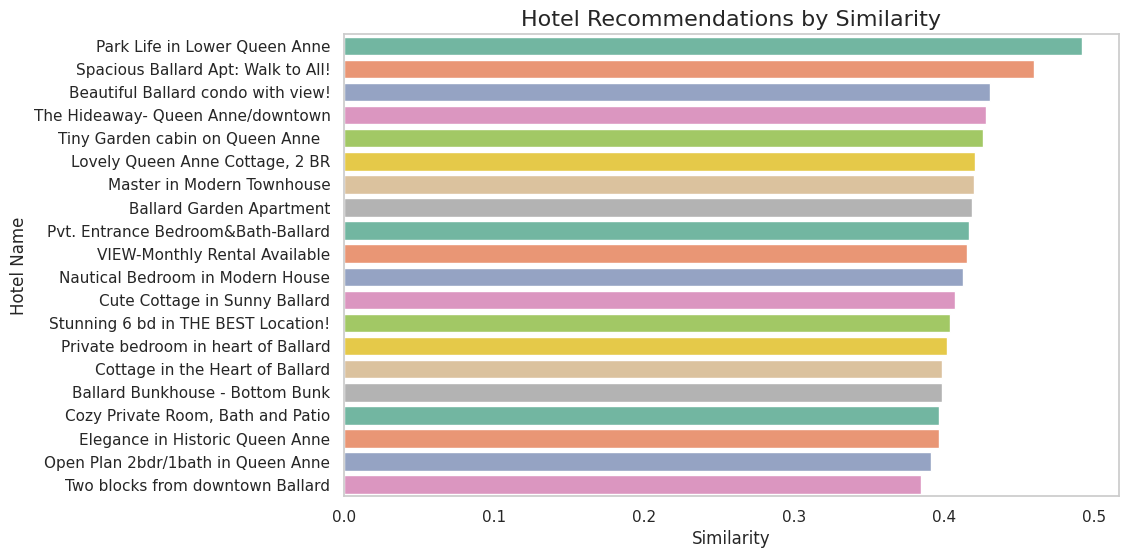

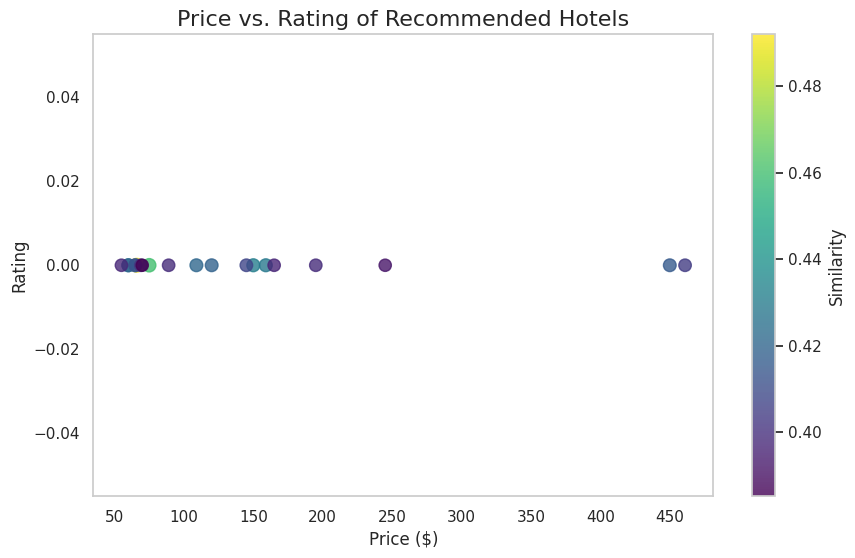

In [45]:
# User Input
user_input = "I want a hotel with breakfast included, a high rating, and affordable price."

# Generate recommendations
recommendation, filtered_data = recommend_hotels_with_rag(user_input,
                                                          filtered_data.head(100),  # Use the first 100 rows for processing
                                                          embedding_model,
                                                          tokenizer,
                                                          model,
                                                          top_n=20  # Retrieve top 20 similar hotels
                                                         )

# Plot the results
top_hotels = filtered_data.sort_values(by="similarity", ascending=False).head(20)
print("Top 20 Recommended Hotels")
plot_recommendations(top_hotels)

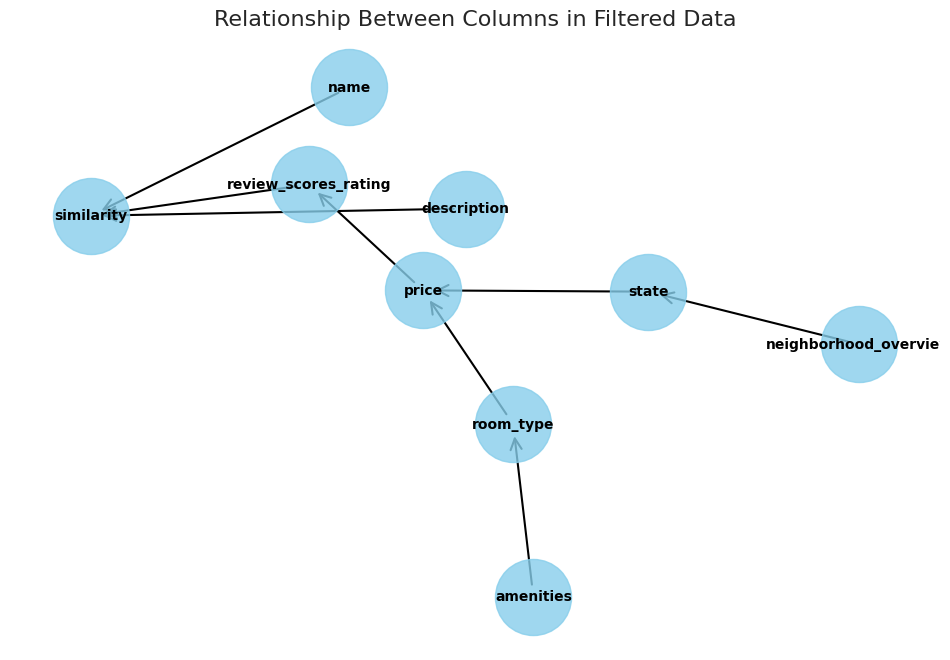

In [46]:
import networkx as nx

# Create the graph
G = nx.DiGraph()  # Directed graph

# Add nodes (columns from the dataset)
columns = list(filtered_data.columns)
G.add_nodes_from(columns)

# Add edges (relationships between columns)
# Logical or contextual relationships based on the dataset are defined here
edges = [
    ("description", "similarity"),  # Description influences similarity
    ("name", "similarity"),         # Name may have relevance for similarity
    ("price", "review_scores_rating"),  # Price may relate to review scores
    ("review_scores_rating", "similarity"),  # Ratings impact similarity
    ("neighborhood_overview", "state"),  # Neighborhood is related to the state
    ("room_type", "price"),  # Room type influences price
    ("amenities", "room_type"),  # Amenities are related to room type
    ("state", "price"),  # State may influence price
]

G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Automatically arrange nodes
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20, edge_color="black", width=1.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black", font_weight="bold")

# Graph title
plt.title("Relationship Between Columns in Filtered Data", fontsize=16)
plt.axis("off")  # Hide axes
plt.show()

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Concatenate all descriptions into a single text
all_descriptions = " ".join(filtered_data["description"].dropna().tolist())

# Extract keywords using TF-IDF
# Limit to 100 keywords, remove English stop words
vectorizer = TfidfVectorizer(max_features=100, stop_words="english")  
X = vectorizer.fit_transform([all_descriptions])
keywords = vectorizer.get_feature_names_out()

# Generate embeddings for the keywords
# Lightweight embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")  
word_embeddings = model.encode(keywords)

# Compute similarity between the keywords
similarity_matrix = cosine_similarity(word_embeddings)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [48]:
# Check extracted keywords and their similarities
print("Extracted Keywords:", keywords)
print()
print("Similarity Matrix:")
print()
print(similarity_matrix)

# Create a DataFrame with the similarity matrix (optional)
similarity_df = pd.DataFrame(similarity_matrix, index=keywords, columns=keywords)

Extracted Keywords: ['10' 'access' 'amenities' 'anne' 'apartment' 'area' 'available' 'away'
 'ballard' 'basement' 'bath' 'bathroom' 'beautiful' 'bed' 'bedroom'
 'bedrooms' 'best' 'block' 'blocks' 'bus' 'center' 'city' 'clean' 'close'
 'closet' 'coffee' 'comfortable' 'cottage' 'cozy' 'deck' 'dining'
 'downtown' 'dryer' 'easy' 'enjoy' 'equipped' 'family' 'floor' 'free'
 'fully' 'garden' 'great' 'guest' 'guests' 'heart' 'hill' 'home' 'house'
 'just' 'kitchen' 'large' 'laundry' 'level' 'light' 'like' 'living' 'll'
 'located' 'location' 'lots' 'main' 'market' 'minutes' 'modern' 'need'
 'neighborhood' 'new' 'old' 'open' 'park' 'parking' 'patio' 'perfect'
 'place' 'plenty' 'private' 'queen' 'quiet' 'restaurants' 'right' 'room'
 'seattle' 'shared' 'shops' 'shower' 'size' 'small' 'space' 'spacious'
 'stay' 'street' 'studio' 'tv' 'use' 'views' 'walk' 'walking' 'washer'
 'wifi' 'yard']

Similarity Matrix:

[[0.99999994 0.27760088 0.17237958 ... 0.21317902 0.16184616 0.23498777]
 [0.27760088 0.999

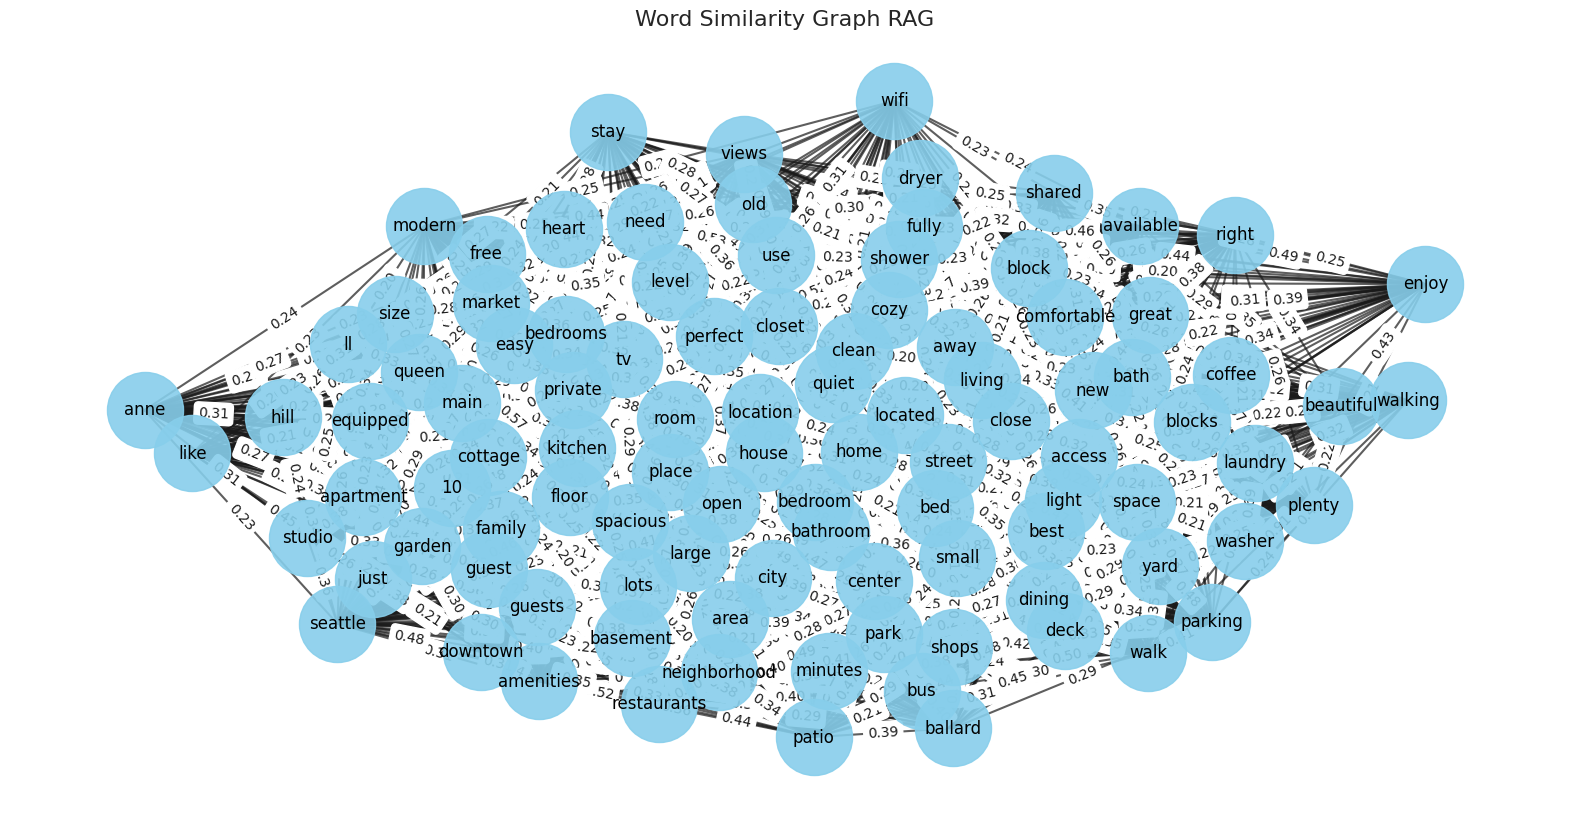

In [49]:
# Create the graph
G = nx.Graph()

# Add nodes (keywords)
G.add_nodes_from(keywords)

# Add edges based on similarity
threshold = 0.2  # Lower threshold to display more connections
for i in range(len(keywords)):
    for j in range(i + 1, len(keywords)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(keywords[i], keywords[j], weight=similarity_matrix[i, j])

# Draw the graph
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, k=0.5)  # Graph layout
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="skyblue", alpha=0.9)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")

# Add weights (similarity) to the edges
edge_labels = nx.get_edge_attributes(G, "weight")
edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}  # Format weights
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Word Similarity Graph RAG", fontsize=16)
plt.axis("off")
plt.show()